# Fetching Data

In [111]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [96]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled"
}

In [97]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [98]:
subjects_available = os.listdir(root_path)

subjects_available

['S5',
 'S2',
 'S3',
 'S4',
 '.DS_Store',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [99]:
try:
    subjects_available.remove(".DS_Store")
except:
    print(subjects_available)

print(subjects_available)

['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']


In [100]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')
        
        index_df = [i for i in range(1, len(data["label"]) + 1)]

        chest_data = {
            body_signal: data["signal"]["chest"][body_signal].reshape(len(data["signal"]["chest"][body_signal]),)
            for body_signal in chest_signal_available
        }
        chest_data["label_id"] = [label if (label >= 0) and (label < 6) else 5 for label in data["label"]]
        chest_data["label"] = [pacient_state[label] if (label >= 0) and (label < 6) else pacient_state[5] for label in data["label"]]
        chest_data["subject"] = data["subject"]

        chest_df_list.append(pd.DataFrame(chest_data, index = index_df))
        
    return chest_df_list

In [101]:
input_chest_data = get_input_chest_data(subjects_available)

KeyboardInterrupt: 

# Investigating Data

In [ ]:
sample_df = input_chest_data[0]

sample_df.sample(20)

,ECG,EMG,EDA,Temp,Resp,label_id,label,subject
3063564,-0.086472,-0.015976,10.102081,34.329102,5.427551,0,Not Defined/Transient,S5
187312,-0.041290,-0.034927,6.612015,34.339813,-0.445557,0,Not Defined/Transient,S5
237557,-0.021103,0.050674,5.606842,34.500549,-1.223755,1,Baseline,S5
1483904,-0.041290,0.002335,5.427933,34.940247,2.870178,3,Amusement,S5
677468,0.026276,-0.007645,3.726959,34.704681,2.459717,1,Baseline,S5
1841828,0.043808,-0.031906,8.359909,34.989563,0.799561,0,Not Defined/Transient,S5
1714088,-0.017166,-0.011398,8.775711,34.955627,2.336121,5,Error/Not Labeled,S5
3154926,-0.044357,-0.003983,11.412430,34.402527,-2.473450,5,Error/Not Labeled,S5
3749970,-0.035934,0.007919,7.403183,34.521973,6.718445,0,Not Defined/Transient,S5
1898712,-0.100754,0.000687,7.870102,34.958710,4.295349,4,Meditation,S5


In [ ]:
sample_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,4380600.0,0.001121,0.250579,-1.499359,-0.064636,-0.026321,0.017899,1.499954
EMG,4380600.0,-0.003708,0.015883,-0.732056,-0.010391,-0.003159,0.003525,0.331833
EDA,4380600.0,7.307906,2.320313,3.402710,5.461502,7.151794,9.448624,12.734604
Temp,4380600.0,34.702957,0.226590,33.850616,34.568024,34.755402,34.872375,35.461884
Resp,4380600.0,0.055553,4.303221,-25.990295,-2.285767,-0.465393,2.394104,33.428955
label_id,4380600.0,1.232982,1.547393,0.000000,0.000000,1.000000,2.000000,5.000000


In [ ]:
sample_df["label_id"].unique()

array([0, 1, 5, 3, 4, 2])

<AxesSubplot:>

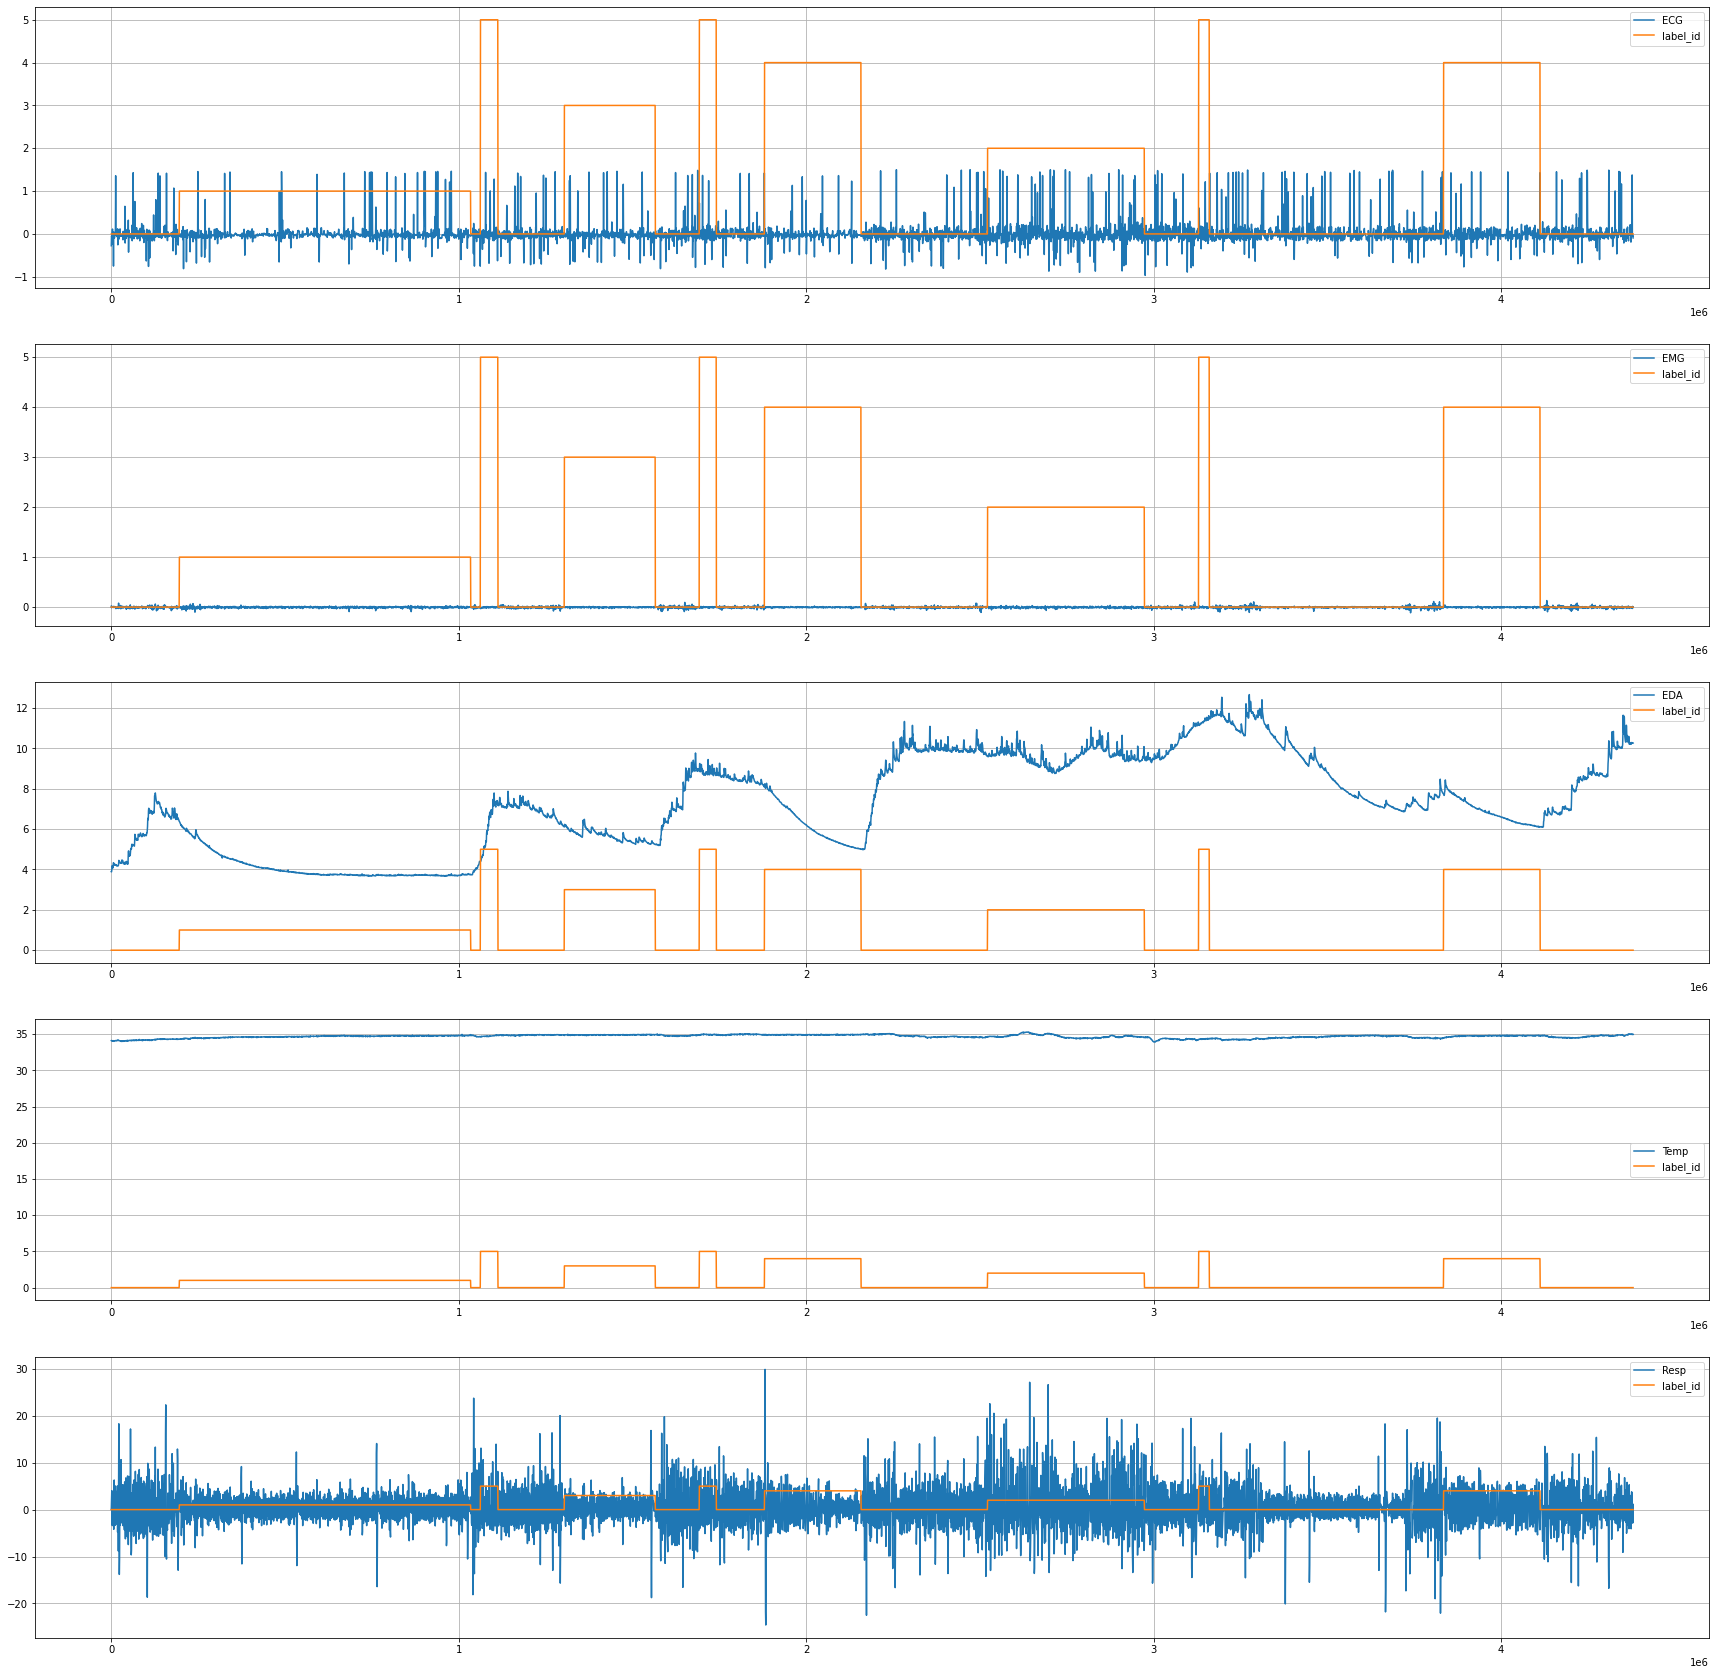

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

sample_df[::700].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)

In [ ]:
from numpy.fft import rfft, irfft, rfftfreq
from scipy import pi, signal, fftpack

In [ ]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
    #text = f"{xmax=}, {ymax=}, (period: {1./xmax} days)" #Eh, Colab has Python 3.6 ... 
    text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} )"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)

In [ ]:
def plot_fft(signal, signal_name=""):
    plt.rcdefaults()

    nobs = len(signal)
    signal_ft = np.abs(rfft(signal))
    signal_freq = rfftfreq(nobs)

    plt.figure(figsize=(20,2))
    plt.plot(signal_freq[2:], signal_ft[2: ])
    annot_max(signal_freq[2:], signal_ft[2: ])
    plt.grid()

    plt.ylabel(f"{signal_name}")
    plt.xlabel('frequency')
    plt.show()

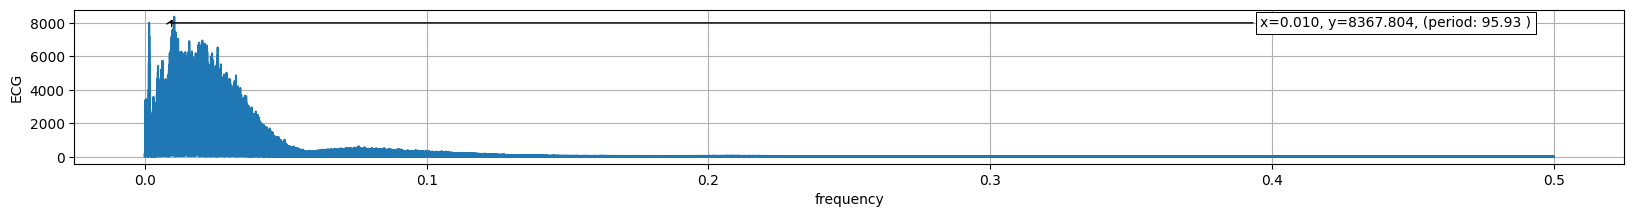

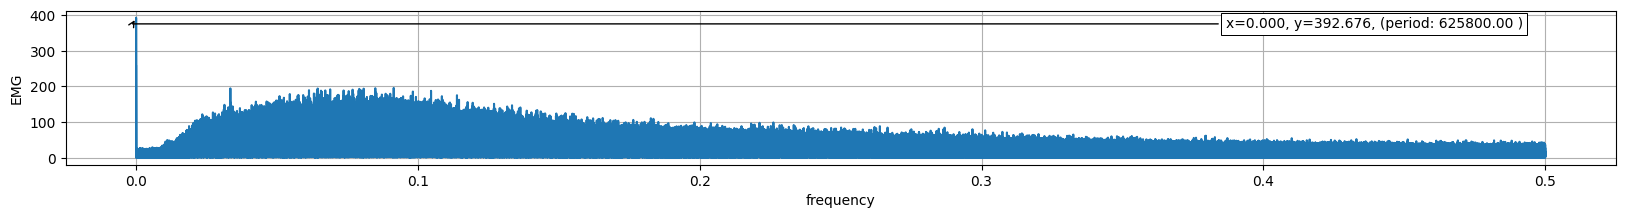

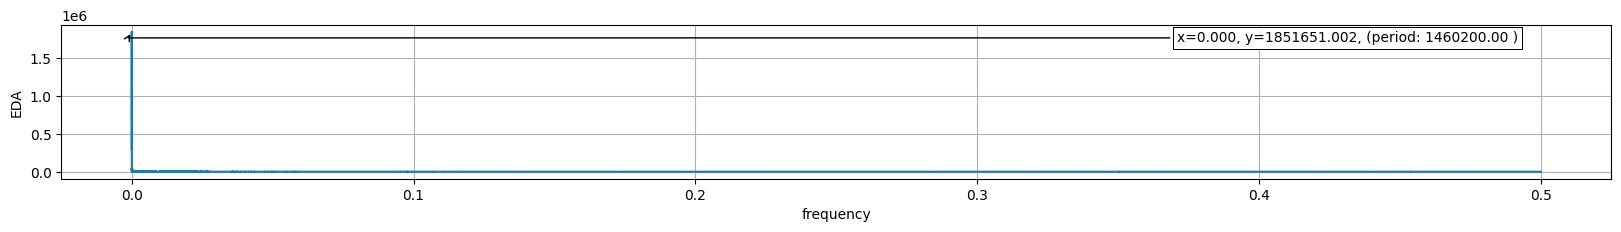

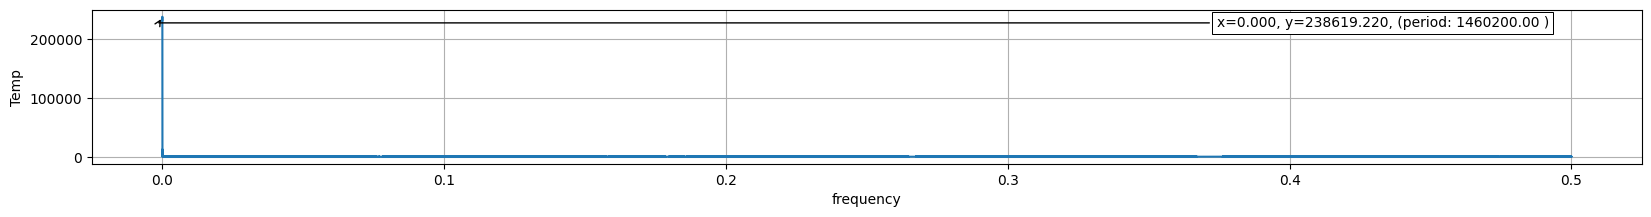

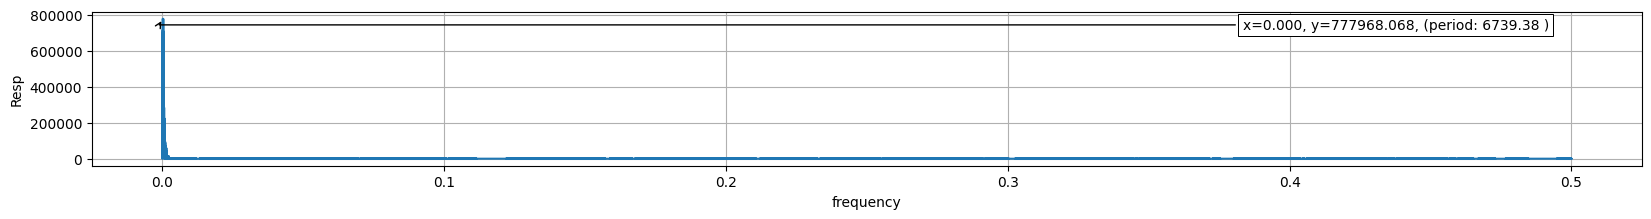

In [ ]:
for signal in sample_df.columns:
    if (signal != "label_id" and signal != "label" and signal != "subject"):
        plot_fft(sample_df[signal], signal)

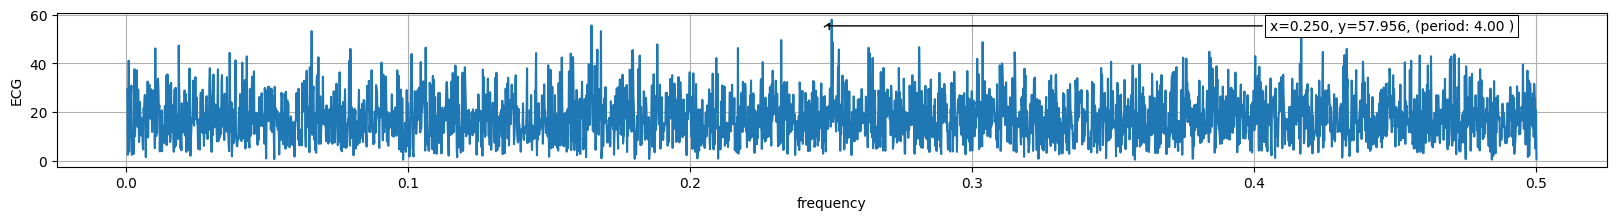

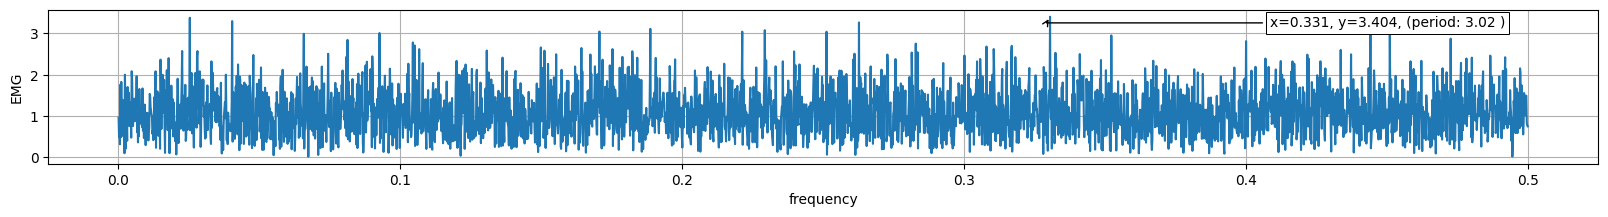

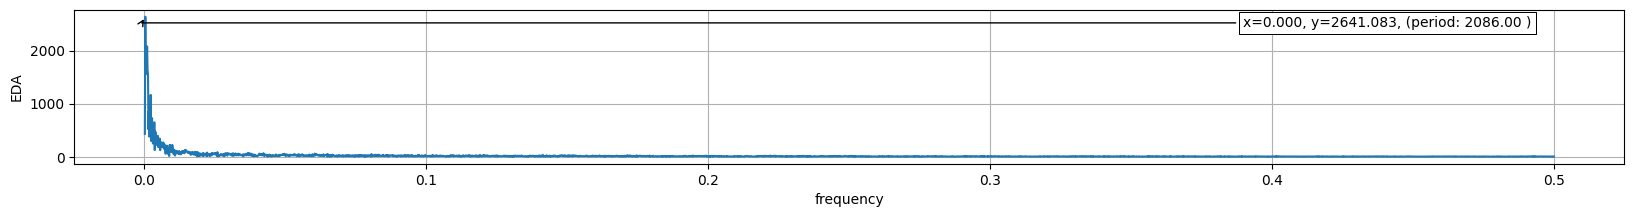

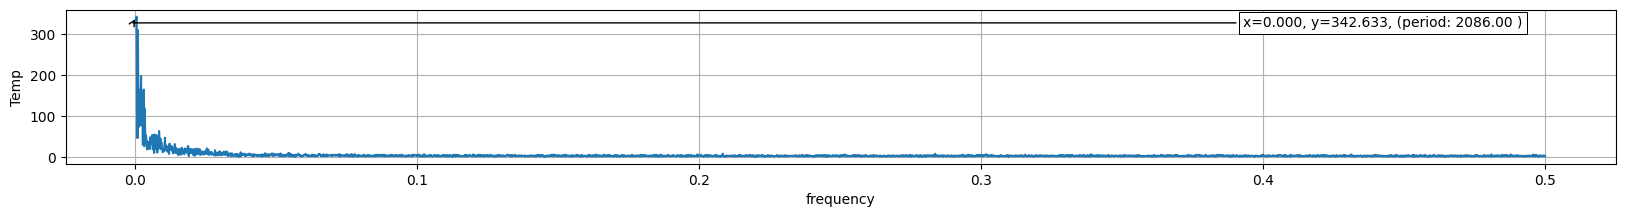

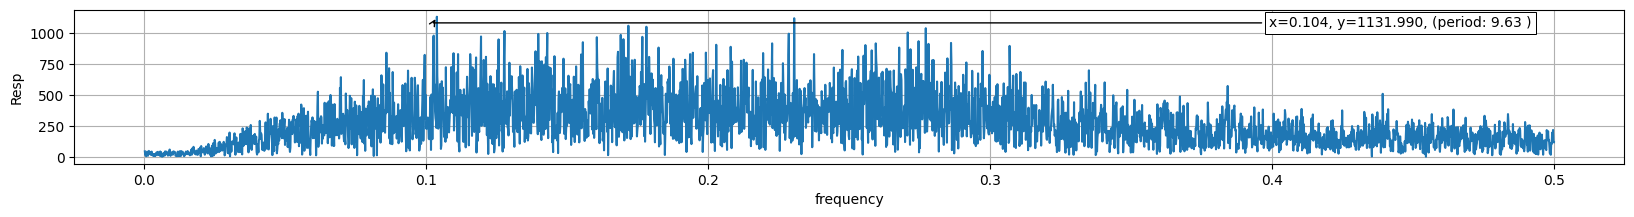

In [ ]:
for signal in sample_df.columns:
    if (signal != "label_id" and signal != "label" and signal != "subject"):
        plot_fft(sample_df[signal][::700], signal)

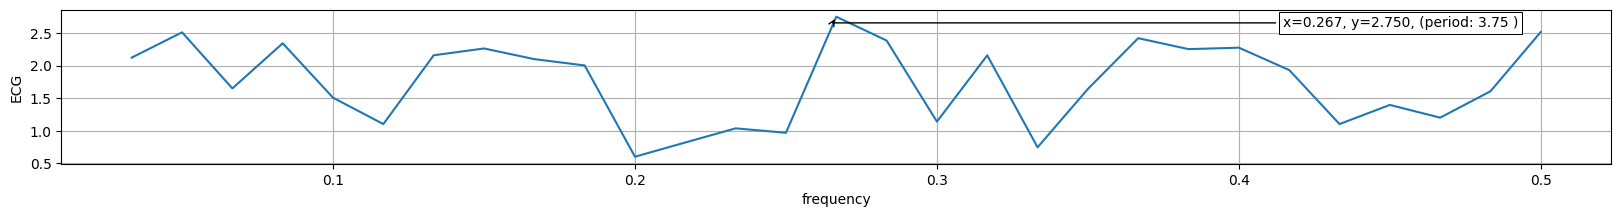

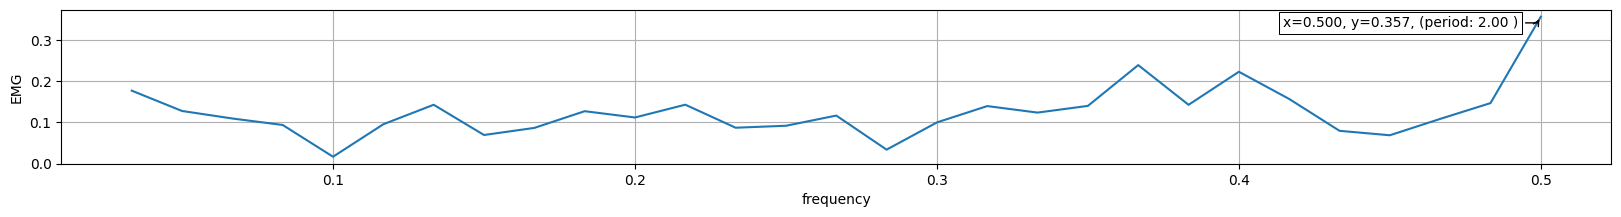

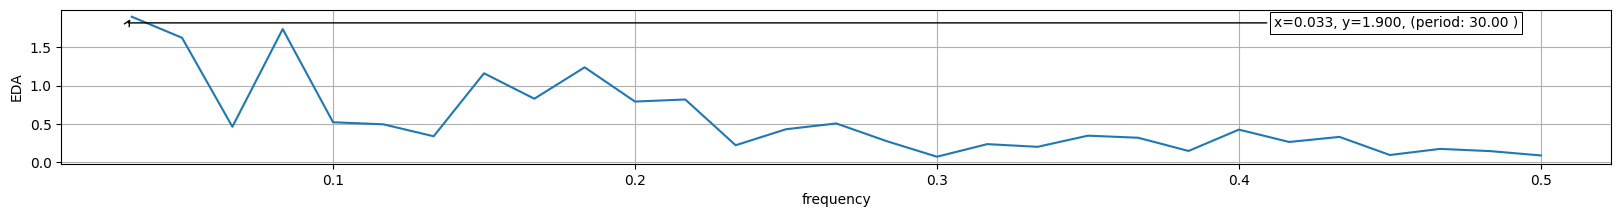

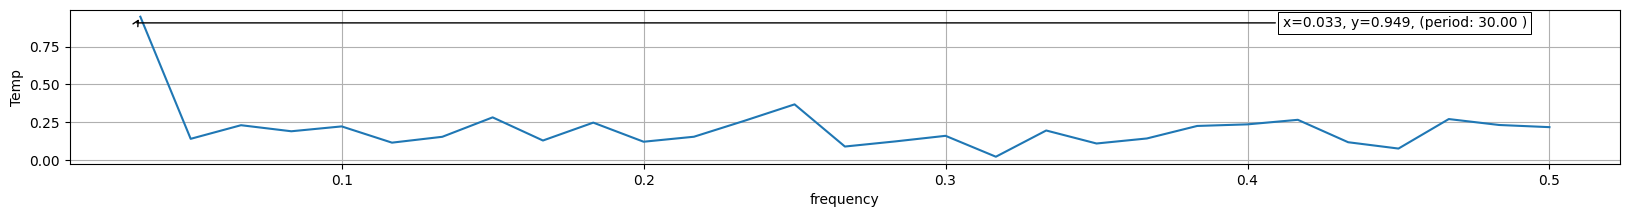

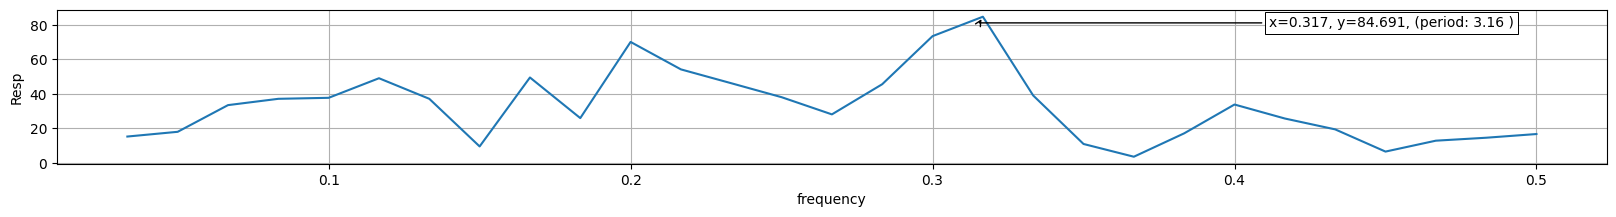

In [ ]:
for signal in sample_df.columns:
    if (signal != "label_id" and signal != "label" and signal != "subject"):
        plot_fft(sample_df[signal][::700][:60], signal)

In [ ]:
def low_pass(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [ ]:
teste = low_pass(sample_df["ECG"])

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_66154/1828417720.py:4: RuntimeWarning: divide by zero encountered in true_divide
  display(1/frequencies)


array([           inf, 2.00000000e-03, 1.00000000e-03, ...,
       9.13117758e-10, 9.13117342e-10, 9.13116925e-10])

In [ ]:
teste

array([0.00109905, 0.00109906, 0.00109907, ..., 0.00109902, 0.00109903,
       0.00109904])

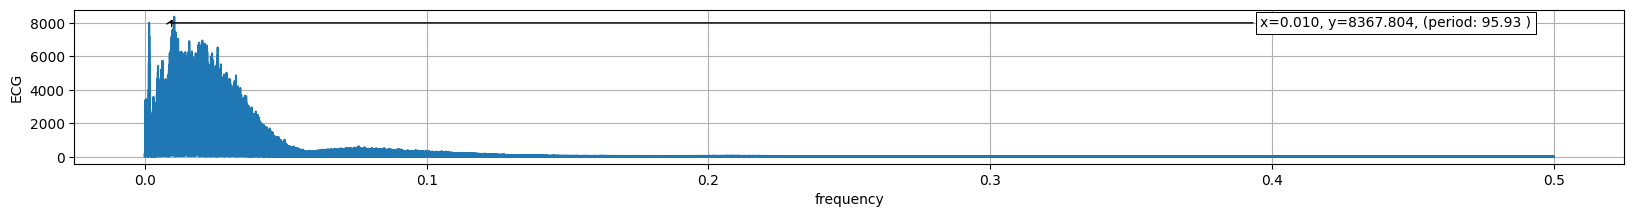

In [ ]:
plot_fft(sample_df["ECG"], "ECG")

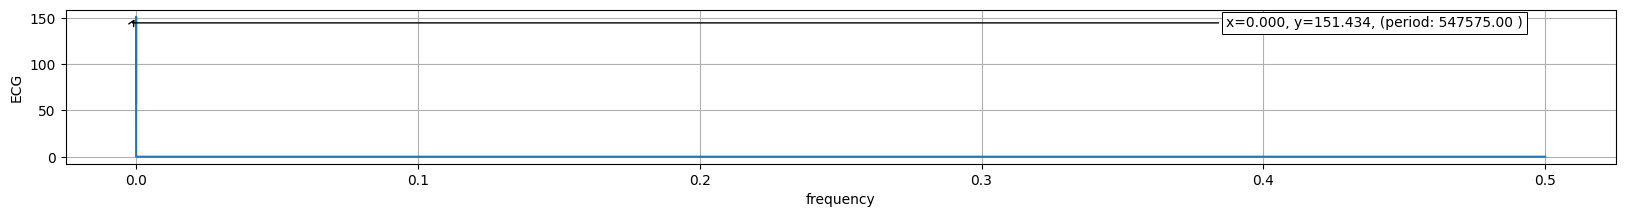

In [ ]:
plot_fft(teste, "ECG")

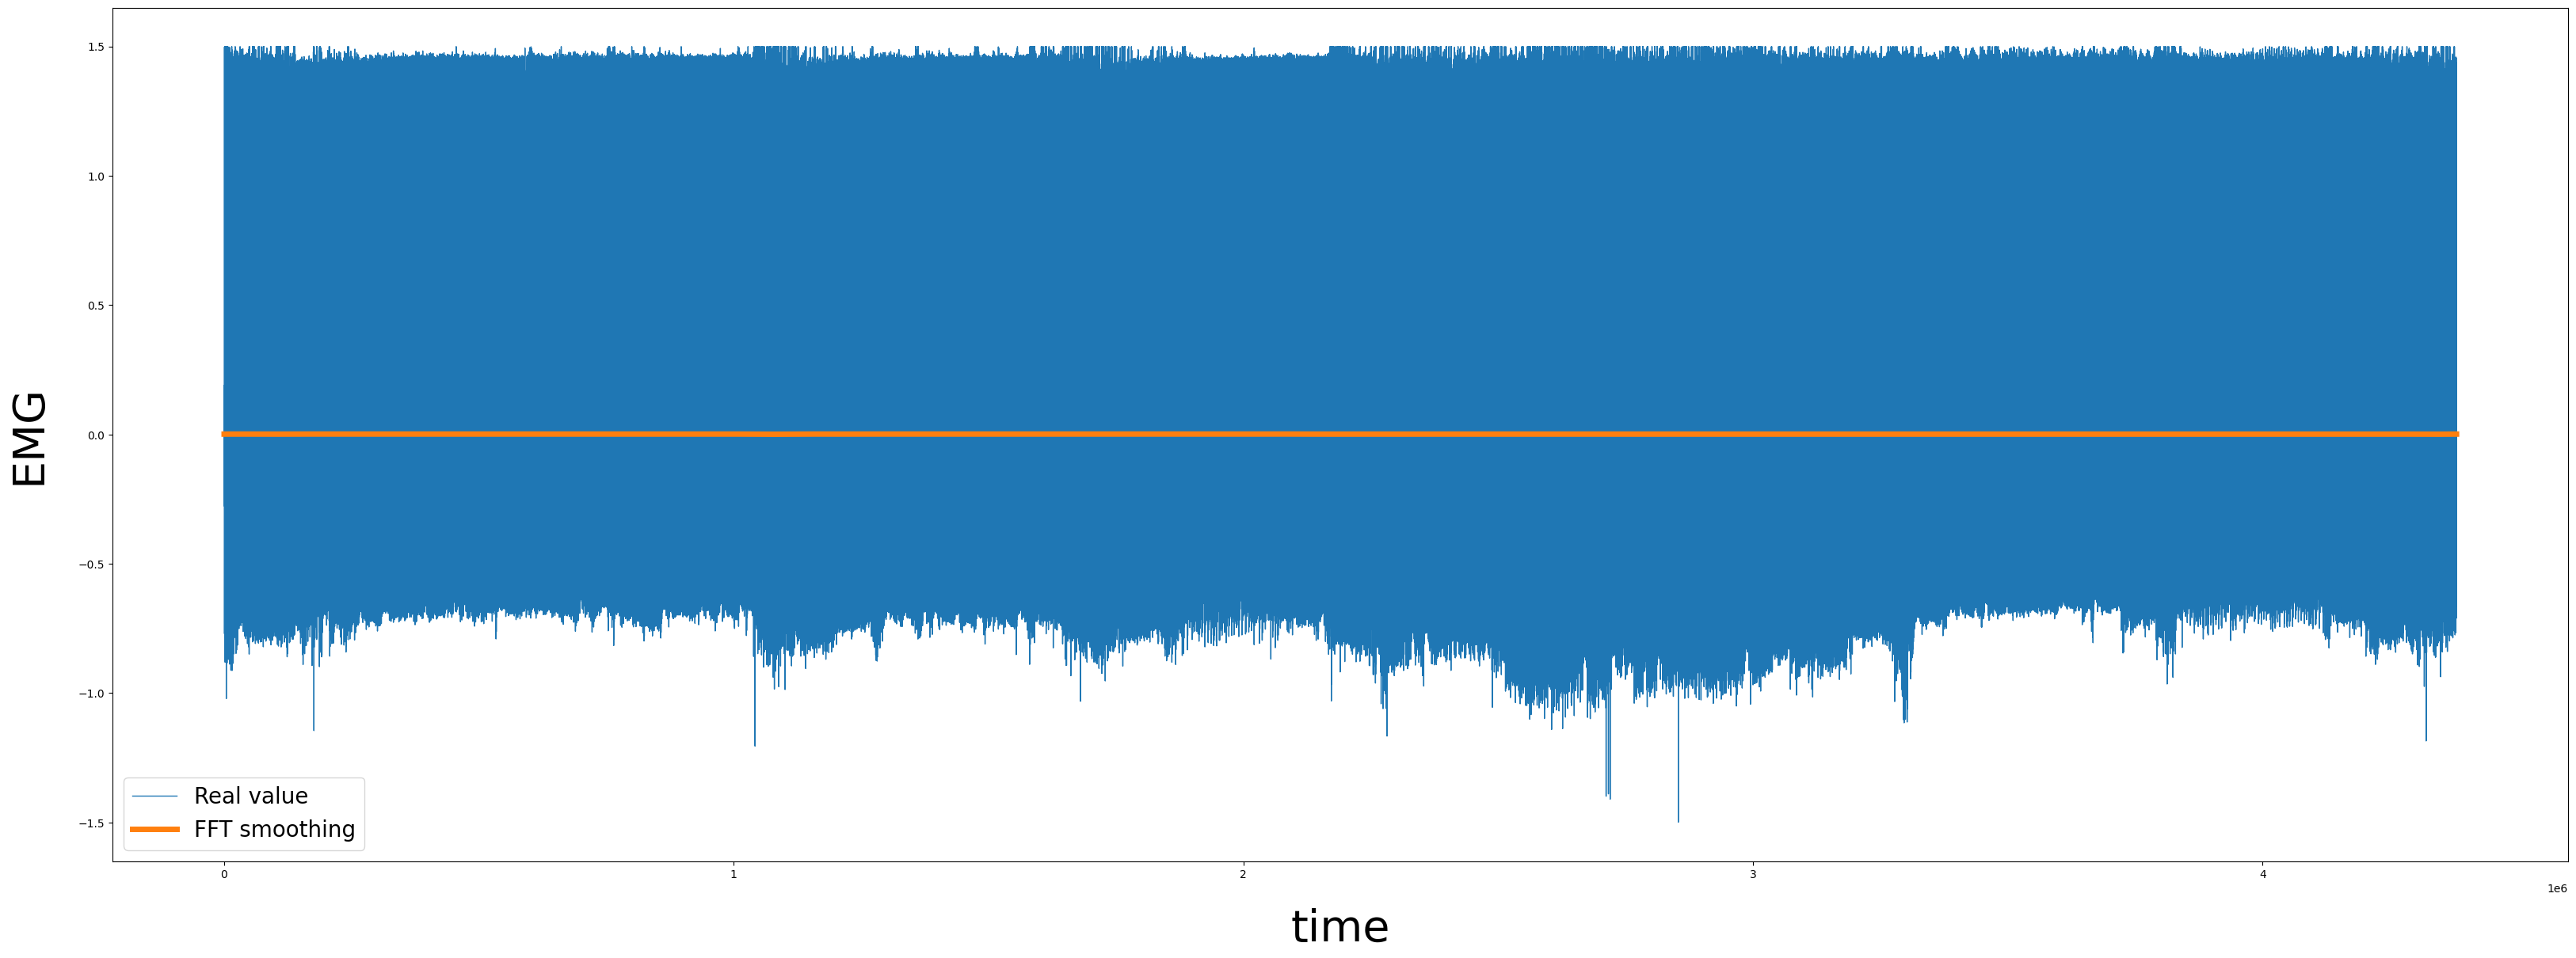

In [ ]:
fig = plt.figure(figsize=(40,14))
plt.xlabel('time',fontsize=40, labelpad=25)
plt.ylabel('EMG',fontsize=40, labelpad=25)
plt.plot(sample_df["ECG"], linewidth=1)
plt.plot(teste, linewidth=5)
plt.legend(['Real value','FFT smoothing'], prop={'size': 20})
plt.title('',fontsize=40, pad=30)

plt.show()

In [ ]:
sample_corr_df  = sample_df.corr("pearson")

sample_corr_df

,ECG,EMG,EDA,Temp,Resp,label_id
ECG,1.000000,-0.038543,-0.000210,-0.000223,-0.005208,0.000061
EMG,-0.038543,1.000000,-0.021898,-0.006276,-0.000312,0.003988
EDA,-0.000210,-0.021898,1.000000,-0.213464,-0.003151,-0.186922
Temp,-0.000223,-0.006276,-0.213464,1.000000,0.001937,0.346217
Resp,-0.005208,-0.000312,-0.003151,0.001937,1.000000,0.000427
label_id,0.000061,0.003988,-0.186922,0.346217,0.000427,1.000000


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

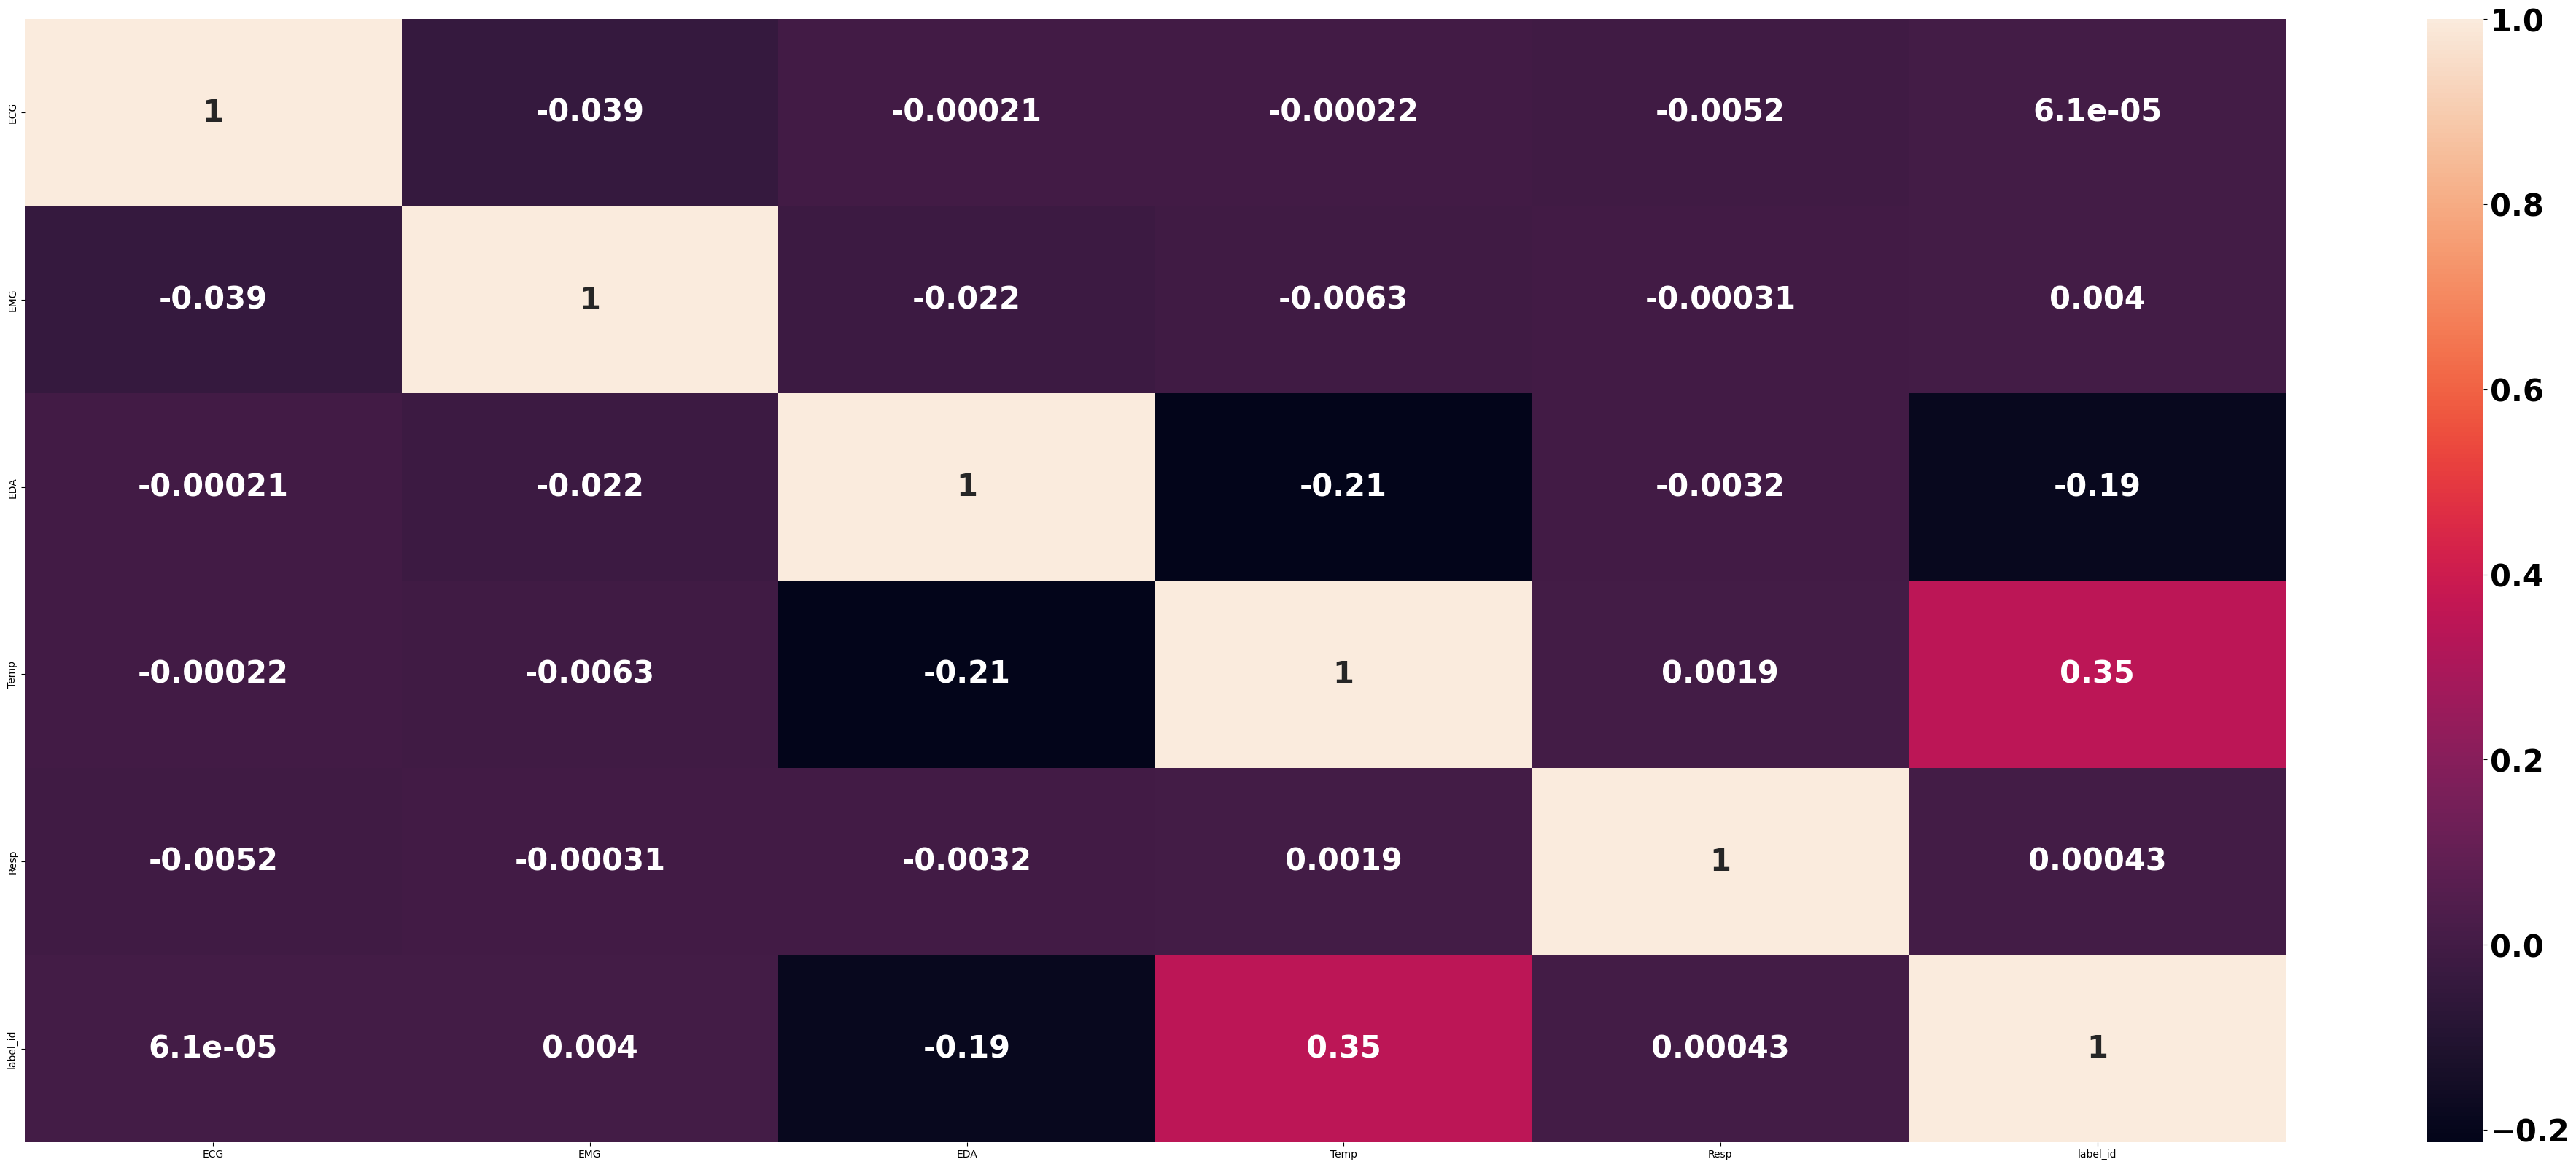

In [ ]:
fig,ax_corr = plt.subplots(1, 1, figsize=(50,20))

font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

sn.heatmap(sample_corr_df, annot=True, ax=ax_corr)

# Cleaning Data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [ ]:
pacient_state_list  = [[state, pacient_state[state]] for state in pacient_state]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(pacient_state_list)

enc.categories_

[array([0, 1, 2, 3, 4, 5], dtype=object),
 array(['Amusement', 'Baseline', 'Error/Not Labeled', 'Meditation',
        'Not Defined/Transient', 'Stress'], dtype=object)]

In [ ]:
win_size = 60 # represent 1 minute

def simple_rolling_z_score(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [ ]:
def rolling_z_score(df, win_size):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [ ]:
clean_chest_data = []

for data_df in input_chest_data:

    # resampling data choosing one point each 700 points

    resample_data_df = data_df[::700]

    # apllying one hot encoder

    # label = resample_data_df.pop("label").to_numpy()
    # label_id = resample_data_df.pop("label_id").to_numpy()
    resample_data_df.pop("label")

    # label_list = [[label_id[i], label[i]] for i in range(len(resample_data_df))]

    # target = enc.transform(label_list).toarray()

    target = resample_data_df.pop("label_id").to_numpy()

    # applying rolling score-z

    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    nodmalized_data_df = rolling_z_score(
        resample_data_df,
        win_size
    )

    # tuple = (normalized_data_df, target, subject_label)

    clean_chest_data.append((nodmalized_data_df, target, subject_label))



In [ ]:
sample = clean_chest_data[0]

In [ ]:
sample

(              ECG       EMG       EDA      Temp      Resp
 1       -1.141354  1.010902 -3.086350  0.761450  0.014113
 701     -0.180240 -0.664806 -3.502281  0.003950  0.354657
 1401    -0.274072  0.947775 -3.141712  0.444722  0.807513
 2101     0.051459  0.534775 -1.374533  0.391319 -0.447787
 2801     0.203342  0.187253 -1.059586 -0.591657 -0.676844
 ...           ...       ...       ...       ...       ...
 4377101  3.688604  0.490229 -0.347143  1.430297  1.046071
 4377801 -0.220608 -1.806449 -0.304009  1.203311 -0.949383
 4378501 -0.370882  1.531488 -0.285798  0.852218 -0.178434
 4379201 -0.321395 -0.591647 -0.291549  0.233314  0.324026
 4379901 -0.474520  0.877932 -0.326055  0.686877 -0.914863
 
 [6258 rows x 5 columns],
 array([0, 0, 0, ..., 0, 0, 0]),
 'S5')

In [ ]:
sample_data_df = sample[0]

In [ ]:
sample_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,6258.0,-0.008513,1.004793,-6.563428,-0.307366,-0.116652,0.119997,7.582440
EMG,6258.0,0.000242,1.035429,-6.152012,-0.568847,0.044271,0.590430,5.852986
EDA,6258.0,0.345882,1.400994,-4.466730,-0.764205,0.376400,1.631442,5.557065
Temp,6258.0,-0.156492,1.214242,-4.190432,-0.991951,-0.072184,0.701792,4.071720
Resp,6258.0,-0.003516,1.021687,-5.952565,-0.662984,-0.139023,0.654771,4.669473


In [ ]:
sample_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 1 to 4379901
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ECG     6258 non-null   float64
 1   EMG     6258 non-null   float64
 2   EDA     6258 non-null   float64
 3   Temp    6258 non-null   float32
 4   Resp    6258 non-null   float64
dtypes: float32(1), float64(4)
memory usage: 268.9 KB


In [ ]:
sample_target = sample[1]

In [ ]:
sample_target

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
unique_values = np.unique(sample_target, axis=0)

In [ ]:
unique_values

array([0, 1, 2, 3, 4, 5])

In [ ]:
# decode_unique_values = enc.inverse_transform(unique_values)

In [ ]:
# decode_unique_values

# Windowing

In [ ]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    return unique[most_repeted_element_index[0][0]]

In [ ]:
def get_window_feature_and_related_target(df, np_array, win_size):
    windows_list = []
    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        windows_list.append((df[slicer].to_numpy(), get_most_repeted_element(np_array[i:win_size+i])))
    return np.array(windows_list)

In [ ]:
sample_window_target = get_window_feature_and_related_target(sample_data_df, sample_target, win_size)

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_66154/1102965131.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [ ]:
sample_window_target[0][0]

array([[-1.14135380e+00,  1.01090174e+00, -3.08635004e+00,
         7.61449635e-01,  1.41128001e-02],
       [-1.80240021e-01, -6.64805531e-01, -3.50228098e+00,
         3.95013951e-03,  3.54657173e-01],
       [-2.74072260e-01,  9.47774799e-01, -3.14171184e+00,
         4.44722414e-01,  8.07512662e-01],
       [ 5.14586772e-02,  5.34774851e-01, -1.37453252e+00,
         3.91319096e-01, -4.47786975e-01],
       [ 2.03341985e-01,  1.87253041e-01, -1.05958642e+00,
        -5.91656923e-01, -6.76844055e-01],
       [ 5.20270293e-01,  2.42621583e-01, -1.92588078e+00,
         4.79015678e-01,  1.38846882e-01],
       [-1.01082822e+00, -2.14383455e-01, -2.54394250e+00,
        -8.25006723e-01, -5.15933413e-02],
       [ 1.79039367e-02, -1.71774414e-01, -2.60422474e+00,
         5.55276334e-01, -3.85099014e-01],
       [-3.41454189e-01,  8.86010104e-01, -6.30514547e-01,
        -1.45706904e+00,  6.88676762e-01],
       [-3.26528244e+00, -2.38711880e-02,  4.81683492e-01,
        -6.36333823e-01

In [ ]:
sample_window_target[0][1]

0

In [ ]:
sample_window_target[1]

array([array([[-1.80240021e-01, -6.64805531e-01, -3.50228098e+00,
         3.95013951e-03,  3.54657173e-01],
       [-2.74072260e-01,  9.47774799e-01, -3.14171184e+00,
         4.44722414e-01,  8.07512662e-01],
       [ 5.14586772e-02,  5.34774851e-01, -1.37453252e+00,
         3.91319096e-01, -4.47786975e-01],
       [ 2.03341985e-01,  1.87253041e-01, -1.05958642e+00,
        -5.91656923e-01, -6.76844055e-01],
       [ 5.20270293e-01,  2.42621583e-01, -1.92588078e+00,
         4.79015678e-01,  1.38846882e-01],
       [-1.01082822e+00, -2.14383455e-01, -2.54394250e+00,
        -8.25006723e-01, -5.15933413e-02],
       [ 1.79039367e-02, -1.71774414e-01, -2.60422474e+00,
         5.55276334e-01, -3.85099014e-01],
       [-3.41454189e-01,  8.86010104e-01, -6.30514547e-01,
        -1.45706904e+00,  6.88676762e-01],
       [-3.26528244e+00, -2.38711880e-02,  4.81683492e-01,
        -6.36333823e-01, -1.97923434e-01],
       [ 1.77439039e-01, -4.28558251e-01, -1.25683631e-01,
         9.59694

In [ ]:
model_data = []
model_features = []
model_targets = []
subjects_list = []

for data in clean_chest_data:

    data_df = data[0]
    data_target = data[1]
    data_subject = data[2]

    window_target = get_window_feature_and_related_target(data_df, data_target, win_size)

    model_data.append(window_target)
    model_features.append(window_target[:,0])
    model_targets.append(window_target[:,1])
    subjects_list.append(data_subject)
    

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_66154/1102965131.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [ ]:
# model_data[subject][specific window_feature_target][feature or target]

len(model_data)

15

In [ ]:
# model_features[all windows_feature of a subject][specific feature]
# model_targets[all windows_target of a subject][specific target]

(model_data[0][0][0] == model_features[0][0]).all()

True

In [ ]:
(model_data[0][0][1] == model_targets[0][0]).all()

True

In [ ]:
(sample_window_target[0][0] == model_features[0][0]).all()

True

In [ ]:
(sample_window_target[0][1] == model_data[0][0][1]).all()

True

In [ ]:
# Number of windows_features of the first pacient

len(model_features[0])

6199

In [ ]:
# Number of targets of the each window

len(model_targets[0])

6199

In [ ]:
# Size of a window

len(model_features[0][0])

60

In [ ]:
print(f'For the window feature: \n\n {model_features[0][0]}\n\n')
print(f'With the zize: {len(model_features[0][0])}\n\n')
print(f'We have the following encoded mental state: \n\n {model_targets[0][0]}')

For the window feature: 

 [[-1.14135380e+00  1.01090174e+00 -3.08635004e+00  7.61449635e-01
   1.41128001e-02]
 [-1.80240021e-01 -6.64805531e-01 -3.50228098e+00  3.95013951e-03
   3.54657173e-01]
 [-2.74072260e-01  9.47774799e-01 -3.14171184e+00  4.44722414e-01
   8.07512662e-01]
 [ 5.14586772e-02  5.34774851e-01 -1.37453252e+00  3.91319096e-01
  -4.47786975e-01]
 [ 2.03341985e-01  1.87253041e-01 -1.05958642e+00 -5.91656923e-01
  -6.76844055e-01]
 [ 5.20270293e-01  2.42621583e-01 -1.92588078e+00  4.79015678e-01
   1.38846882e-01]
 [-1.01082822e+00 -2.14383455e-01 -2.54394250e+00 -8.25006723e-01
  -5.15933413e-02]
 [ 1.79039367e-02 -1.71774414e-01 -2.60422474e+00  5.55276334e-01
  -3.85099014e-01]
 [-3.41454189e-01  8.86010104e-01 -6.30514547e-01 -1.45706904e+00
   6.88676762e-01]
 [-3.26528244e+00 -2.38711880e-02  4.81683492e-01 -6.36333823e-01
  -1.97923434e-01]
 [ 1.77439039e-01 -4.28558251e-01 -1.25683631e-01  9.59694013e-02
  -8.29354685e-01]
 [-1.83612742e-01  1.65654157e-01 -5.6

# Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation, GRU, GaussianNoise, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import convert_to_tensor

import datetime

In [ ]:
# In order to validate the model, we are gonna drop the data of one 

model_features_validation = model_features.pop()
model_targets_validation = model_targets.pop()
print(f'Validation Subject: {subjects_list.pop()}')
print(f'Validation Feature Shape and Type: {model_features_validation.shape}, {type(model_features_validation)}')
print(f'Validation Target Shape and Type: {model_targets_validation.shape}, {type(model_targets_validation)}')

Validation Subject: S15
Validation Feature Shape and Type: (5193,), <class 'numpy.ndarray'>
Validation Target Shape and Type: (5193,), <class 'numpy.ndarray'>


In [ ]:
with open("processed_data/validation_data.pickle", "wb") as f:
    pickle.dump({
        "features": model_features_validation,
        "targets": model_targets_validation,
    }, f)

In [ ]:
model_targets_validation

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [ ]:
model_features[0].shape

(6199,)

In [ ]:
model_targets[0].shape

(6199,)

In [ ]:
# Group data of all subjects in one array

features = model_features[0]
targets = model_targets[0]

for i in range(1, len(subjects_list)):
    features = np.concatenate((features, model_features[i]), axis=0)
    targets = np.concatenate((targets, model_targets[i]), axis=0)

In [ ]:
# features: has all windows with size of 60

features.shape, features[0].shape

((80790,), (60, 5))

In [ ]:
# targets: has all targets for each window with size of 60

targets.shape, targets[0].shape

((80790,), ())

In [ ]:
np.unique(targets)

array([0, 1, 2, 3, 4, 5], dtype=object)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, stratify=targets)

In [ ]:
x_train.shape, x_test.shape

((48474,), (32316,))

In [ ]:
y_train.shape, y_test.shape

((48474,), (32316,))

In [ ]:
def convert_data_to_tensor(x_train, x_test, y_train, y_test):
    
    x_train_tensor = convert_to_tensor(
        np.array(
            [convert_to_tensor(data) for data in x_train]
        )
    )
    x_test_tensor = convert_to_tensor(
        np.array(
            [convert_to_tensor(data) for data in x_test]
        )
    )

    y_train_tensor = convert_to_tensor(y_train.reshape(len(y_train),-1), dtype="int64")
    y_test_tensor = convert_to_tensor(y_test.reshape(len(y_test),-1), dtype="int64")

    return x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor

In [ ]:
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = convert_data_to_tensor(x_train, x_test, y_train, y_test)

2021-12-27 18:50:45.922155: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# converting to Tensors

features_tensor = convert_to_tensor(
    np.array(
        [convert_to_tensor(data) for data in features]
    )
)

features_tensor.shape

TensorShape([80790, 60, 5])

In [ ]:
targets

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [ ]:
targets.reshape(len(targets),-1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [ ]:
targets_tensor = convert_to_tensor(targets.reshape(len(targets),-1), dtype="int64")

targets_tensor.shape


TensorShape([80790, 1])

In [ ]:
targets_tensor

<tf.Tensor: shape=(80790, 1), dtype=int64, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])>

In [ ]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(targets), y = targets)
weights = {i : weights[i] for i in range(len(weights))}

In [ ]:
weights

{0: 0.36658408428847566,
 1: 0.8200365408038977,
 2: 1.4531620979926614,
 3: 2.5949123145114665,
 4: 1.2258739985433358,
 5: 6.120454545454545}

In [ ]:
with open("processed_data/trainning_data.pickle", "wb") as f:
    pickle.dump({
        "features_tensor": features_tensor,
        "targets_tensor": targets_tensor,
        "features": features,
        "targets": targets,
        "weights": weights
    }, f)

In [ ]:
targets.shape

(80790,)

In [ ]:
np.unique(targets)

array([0, 1, 2, 3, 4, 5], dtype=object)

In [ ]:
def lstm(model = None):
    model.add(GaussianNoise(0.1))
    model.add(LSTM(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(6))

def gru(model = None):
    model.add(GRU(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(6, activity_regularizer = L2(0.000001), bias_constraint = max_norm(3)))


In [ ]:
# duas lstm uma dropout e uma dense
# testar uma GRU (trocar todas as LSTM por elas)


def create_model(has_activator, last_activation_layer, hidden_layer_type, optimizer):

    model = Sequential()
    hidden_layer_type(model)
    if has_activator:
        model.add(Activation(last_activation_layer))
    model.build()

    model.summary()

    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer, #nadam or rmstrop
        metrics = ["sparse_categorical_accuracy"]
    )

    return model


In [ ]:
models_to_test = {
    # "softmax_lstm_adam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "blue",
    #     "layers": lstm,
    #     "optimizer": "adam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_nadam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "red",
    #     "layers": lstm,
    #     "optimizer": "nadam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_rmsprop": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "green",
    #     "layers": lstm,
    #     "optimizer": "rmsprop",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # }
    "softmax_gru_adam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "yellow",
        "layers": gru,
        "optimizer": "adam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_nadam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "magenta",
        "layers": gru,
        "optimizer": "nadam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_rmsprop": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "cyan",
        "layers": gru,
        "optimizer": "rmsprop",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    }   
}

2021-12-27 18:50:52.344255: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 18:50:52.344270: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 18:50:52.345572: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-27 18:50:52.346337: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 18:50:52.346346: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 18:50:52.346365: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-27 18:50:52.346423: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 18:50:52.346428: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 18:50:52.346465: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session 

In [ ]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17b28e6d0>]},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17aad31c0>]},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17aad3280>]}}

In [ ]:
for model_name in models_to_test:

    has_activator = models_to_test[model_name]["has_activator"]
    activation_layer = models_to_test[model_name]["activator_layer"]
    hidden_layer = models_to_test[model_name]["layers"]
    optimizer = models_to_test[model_name]["optimizer"]
    
    

    model = create_model(has_activator, activation_layer, hidden_layer, optimizer)
    history = model.fit(
        x=x_train_tensor,
        y=y_train_tensor,
        validation_data=(x_test_tensor, y_test_tensor),
        epochs=100,
        shuffle=False,
        class_weight=weights,
        callbacks=models_to_test[model_name]["callbacks"]
    )

    model.save(f"models/stress_detection_{model_name}")

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 46086     
_________________________________________________________________
activation (Activation)      (None, 6)                 0

2021-12-27 18:50:52.706868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


   2/1515 [..............................] - ETA: 4:18 - loss: 1.7677 - sparse_categorical_accuracy: 0.1562 

2021-12-27 18:50:54.550255: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 18:50:54.550272: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 18:50:54.627073: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-27 18:50:54.690183: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


   3/1515 [..............................] - ETA: 6:06 - loss: 1.8057 - sparse_categorical_accuracy: 0.1562

2021-12-27 18:50:54.765336: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/adam/fit/20211227-185052/train/plugins/profile/2021_12_27_18_50_54

2021-12-27 18:50:54.803336: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/adam/fit/20211227-185052/train/plugins/profile/2021_12_27_18_50_54/C02D602YMD6Q.trace.json.gz
2021-12-27 18:50:54.871074: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/adam/fit/20211227-185052/train/plugins/profile/2021_12_27_18_50_54

2021-12-27 18:50:54.873663: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/adam/fit/20211227-185052/train/plugins/profile/2021_12_27_18_50_54/C02D602YMD6Q.memory_profile.json.gz
2021-12-27 18:50:54.878326: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: 

1515/1515 [==============================] - 42s 26ms/step - loss: 1.8585 - sparse_categorical_accuracy: 0.3187 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.5536
Epoch 2/100
1515/1515 [==============================] - 40s 27ms/step - loss: 1.0464 - sparse_categorical_accuracy: 0.5612 - val_loss: 0.7031 - val_sparse_categorical_accuracy: 0.7400
Epoch 3/100
1515/1515 [==============================] - 38s 25ms/step - loss: 0.5509 - sparse_categorical_accuracy: 0.7220 - val_loss: 0.4886 - val_sparse_categorical_accuracy: 0.8356
Epoch 4/100
1515/1515 [==============================] - 37s 24ms/step - loss: 0.3443 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.2331 - val_sparse_categorical_accuracy: 0.9236
Epoch 5/100
1515/1515 [==============================] - 40s 26ms/step - loss: 0.2329 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.1765 - val_sparse_categorical_accuracy: 0.9527
Epoch 6/100
1515/1515 [==============================] - 39s 26ms/step - loss: 0.1708 -

2021-12-27 20:04:07.233243: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_adam/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_adam/assets


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 60, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 46086     
_________________________________________________________________
activation_1 (Activation)    (None, 6)                

2021-12-27 20:04:11.053639: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 20:04:11.053655: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 20:04:11.157892: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-27 20:04:11.187783: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-27 20:04:11.229465: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11

2021-12-27 20:04:11.252005: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11/C02D602YMD6Q.trace.json.gz


   9/1515 [..............................] - ETA: 1:24 - loss: 2.1573 - sparse_categorical_accuracy: 0.1771

2021-12-27 20:04:11.269954: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11

2021-12-27 20:04:11.270571: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11/C02D602YMD6Q.memory_profile.json.gz
2021-12-27 20:04:11.274572: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11
Dumped tool data for xplane.pb to logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11/C02D602YMD6Q.xplane.pb
Dumped tool data for overview_page.pb to logs/softmax/gru/nadam/fit/20211227-185052/train/plugins/profile/2021_12_27_20_04_11/C02D602YMD6Q.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/soft

1515/1515 [==============================] - 43s 28ms/step - loss: 1.7752 - sparse_categorical_accuracy: 0.3294 - val_loss: 1.0237 - val_sparse_categorical_accuracy: 0.5810
Epoch 2/100
1515/1515 [==============================] - 42s 28ms/step - loss: 1.0181 - sparse_categorical_accuracy: 0.5731 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.7381
Epoch 3/100
1515/1515 [==============================] - 41s 27ms/step - loss: 0.5484 - sparse_categorical_accuracy: 0.7271 - val_loss: 0.4891 - val_sparse_categorical_accuracy: 0.8282
Epoch 4/100
1515/1515 [==============================] - 42s 28ms/step - loss: 0.3150 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.2329 - val_sparse_categorical_accuracy: 0.9259
Epoch 5/100
1515/1515 [==============================] - 44s 29ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.1295 - val_sparse_categorical_accuracy: 0.9648
Epoch 6/100
1515/1515 [==============================] - 43s 28ms/step - loss: 0.1692 -

INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_nadam/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_nadam/assets


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 46086     
_________________________________________________________________
activation_2 (Activation)    (None, 6)                

2021-12-27 21:19:30.890996: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-27 21:19:30.891019: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-27 21:19:31.007723: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-27 21:19:31.042413: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-27 21:19:31.073707: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/rmsprop/fit/20211227-185052/train/plugins/profile/2021_12_27_21_19_31



   6/1515 [..............................] - ETA: 2:00 - loss: 2.1362 - sparse_categorical_accuracy: 0.1823

2021-12-27 21:19:31.096861: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/rmsprop/fit/20211227-185052/train/plugins/profile/2021_12_27_21_19_31/C02D602YMD6Q.trace.json.gz
2021-12-27 21:19:31.114322: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/rmsprop/fit/20211227-185052/train/plugins/profile/2021_12_27_21_19_31

2021-12-27 21:19:31.120751: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/rmsprop/fit/20211227-185052/train/plugins/profile/2021_12_27_21_19_31/C02D602YMD6Q.memory_profile.json.gz
2021-12-27 21:19:31.124327: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/softmax/gru/rmsprop/fit/20211227-185052/train/plugins/profile/2021_12_27_21_19_31
Dumped tool data for xplane.pb to logs/softmax/gru/rmsprop/fit/20211227-185052/train/plugins/pro

1515/1515 [==============================] - 44s 28ms/step - loss: 1.8996 - sparse_categorical_accuracy: 0.3098 - val_loss: 1.1208 - val_sparse_categorical_accuracy: 0.5542
Epoch 2/100
1515/1515 [==============================] - 42s 28ms/step - loss: 1.2425 - sparse_categorical_accuracy: 0.5195 - val_loss: 0.8680 - val_sparse_categorical_accuracy: 0.6724
Epoch 3/100
1515/1515 [==============================] - 44s 29ms/step - loss: 0.8143 - sparse_categorical_accuracy: 0.6519 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.7818
Epoch 4/100
1515/1515 [==============================] - 42s 28ms/step - loss: 0.5122 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.3835 - val_sparse_categorical_accuracy: 0.8646
Epoch 5/100
1515/1515 [==============================] - 42s 28ms/step - loss: 0.3516 - sparse_categorical_accuracy: 0.8346 - val_loss: 0.2516 - val_sparse_categorical_accuracy: 0.9151
Epoch 6/100
1515/1515 [==============================] - 42s 28ms/step - loss: 0.2352 -

INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_rmsprop/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_rmsprop/assets


In [ ]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17b28e6d0>],
  'history': <keras.callbacks.History at 0x17cbc44c0>,
  'model': <keras.engine.sequential.Sequential at 0x17b2941f0>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17aad31c0>],
  'history': <keras.callbacks.History at 0x17c6f5550>,
  'model': <keras.engine.sequential.Sequential at 0x17b671c70>},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17aad3280>],
  'history': <keras.callbacks.History a

In [ ]:
history.history

{'loss': [1.8996022939682007,
  1.2424912452697754,
  0.8142978549003601,
  0.5121914744377136,
  0.3516388237476349,
  0.2351895272731781,
  0.17761379480361938,
  0.14404037594795227,
  0.12963652610778809,
  0.11338949203491211,
  0.10565555840730667,
  0.09780292212963104,
  0.08956024050712585,
  0.1073707640171051,
  0.08241906017065048,
  0.08477146178483963,
  0.0814627930521965,
  0.07855810970067978,
  0.07257067412137985,
  0.08807834982872009,
  0.07933102548122406,
  0.0863845944404602,
  0.06927476823329926,
  0.07437865436077118,
  0.0740097388625145,
  0.0761193260550499,
  0.08054247498512268,
  0.06782179325819016,
  0.06789422035217285,
  0.06888836622238159,
  0.07666560262441635,
  0.07493742555379868,
  0.06311430037021637,
  0.07256565988063812,
  0.07471709698438644,
  0.06420233845710754,
  0.07045397162437439,
  0.07387790083885193,
  0.06027607247233391,
  0.06383953243494034,
  0.06477648764848709,
  0.06663084775209427,
  0.05834285169839859,
  0.0808560028

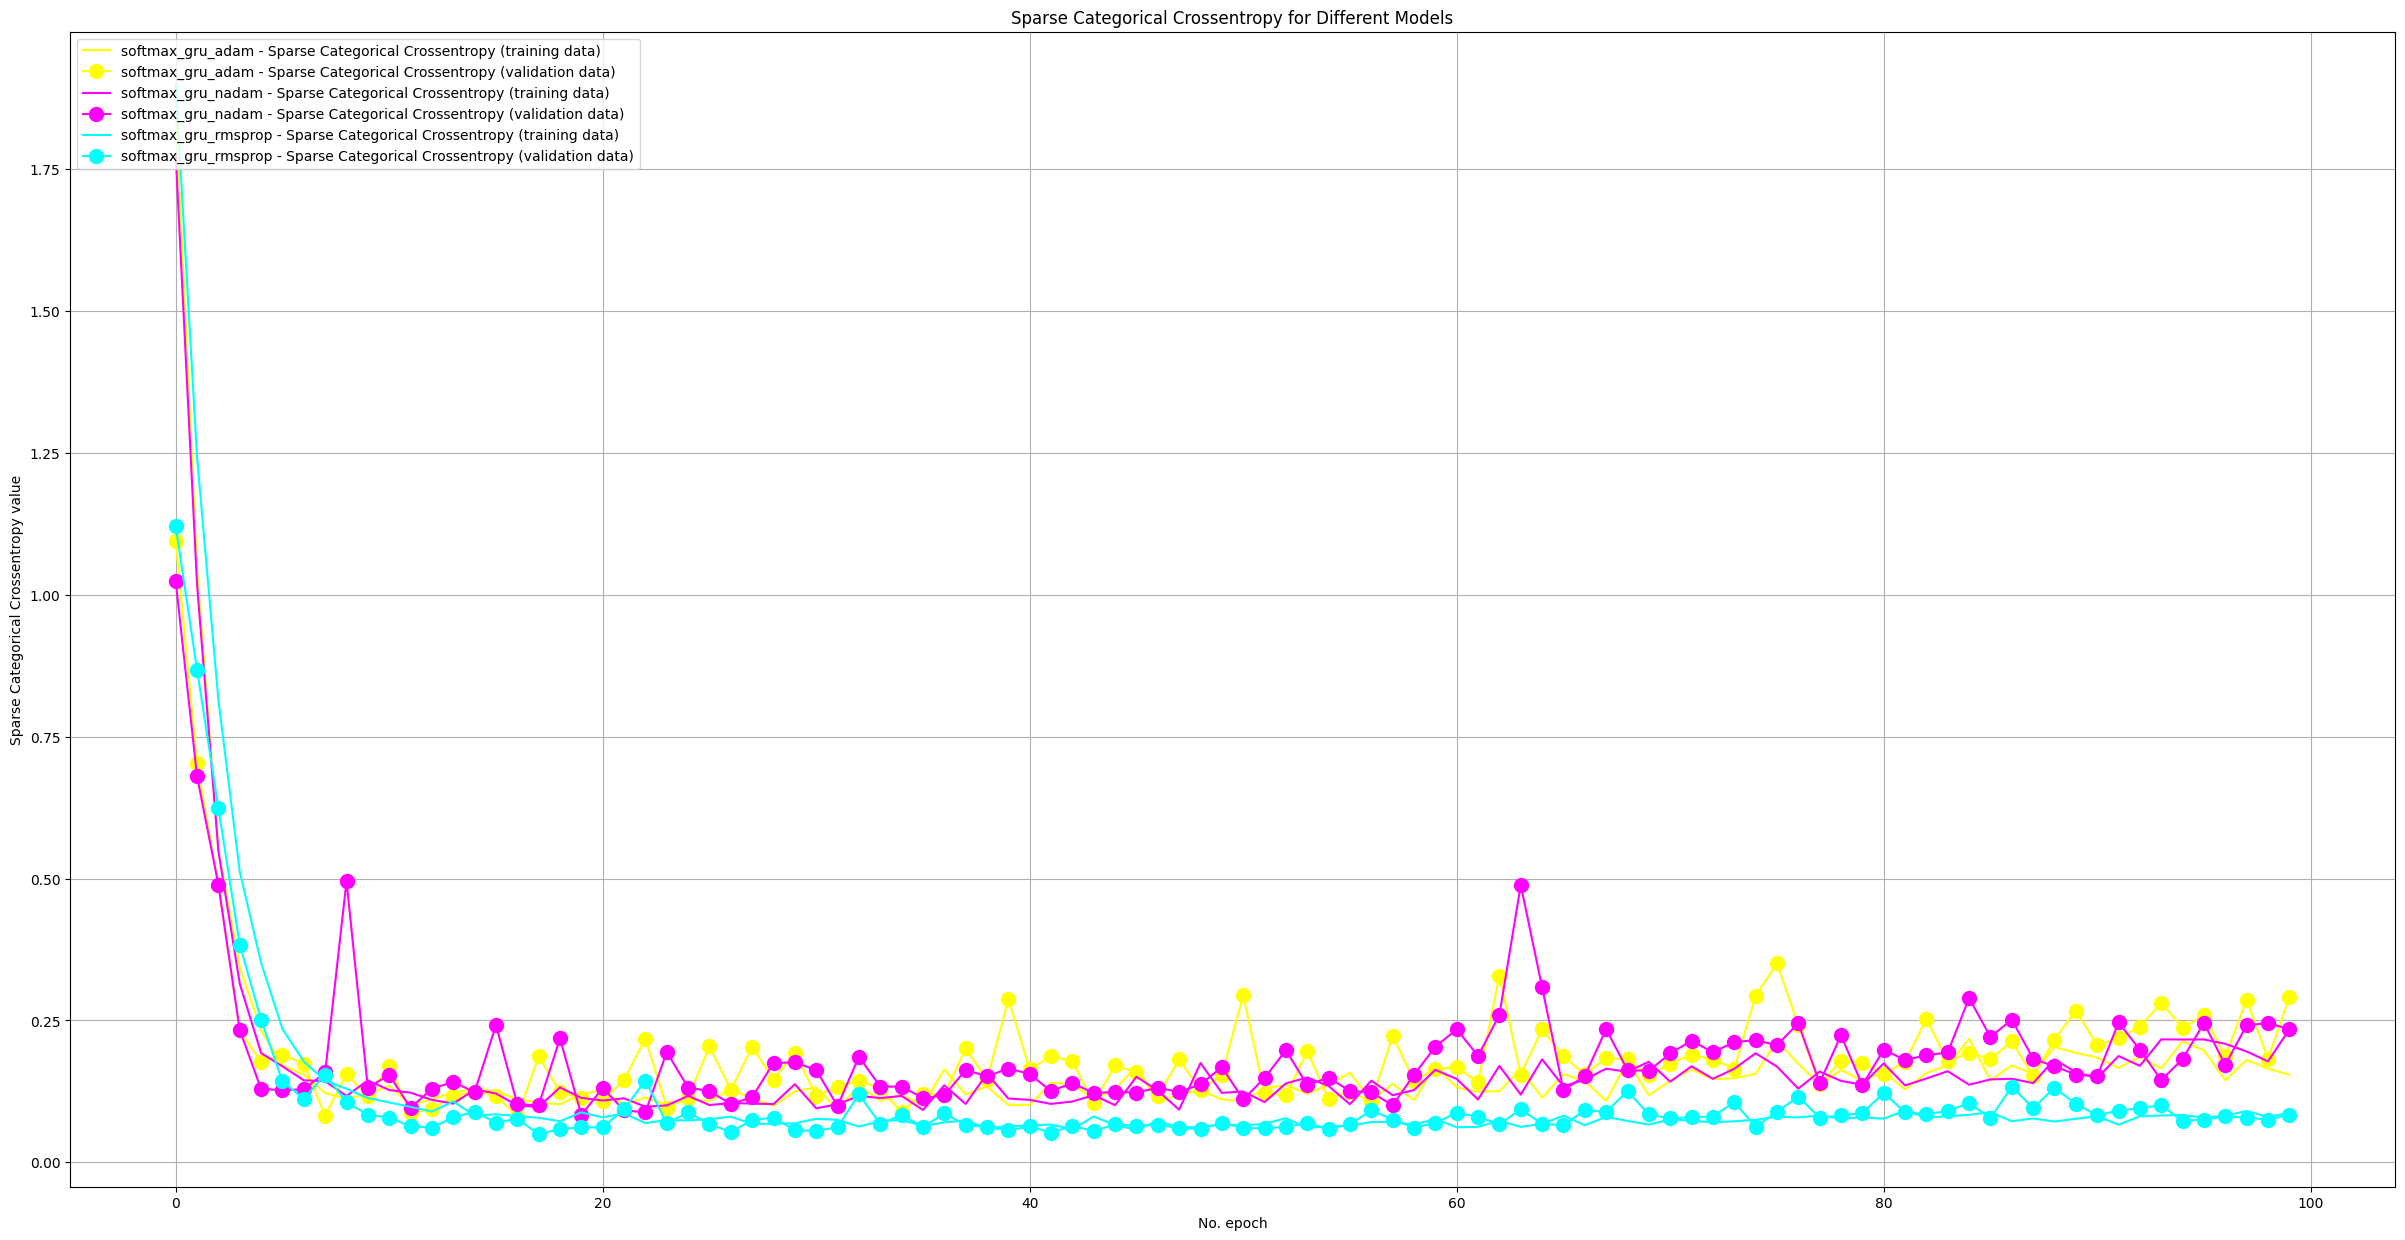

In [ ]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - Sparse Categorical Crossentropy (training data)', color=color_plot)
    plt.plot(history.history['val_loss'], label=f'{model_name} - Sparse Categorical Crossentropy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Crossentropy for Different Models')
plt.ylabel('Sparse Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

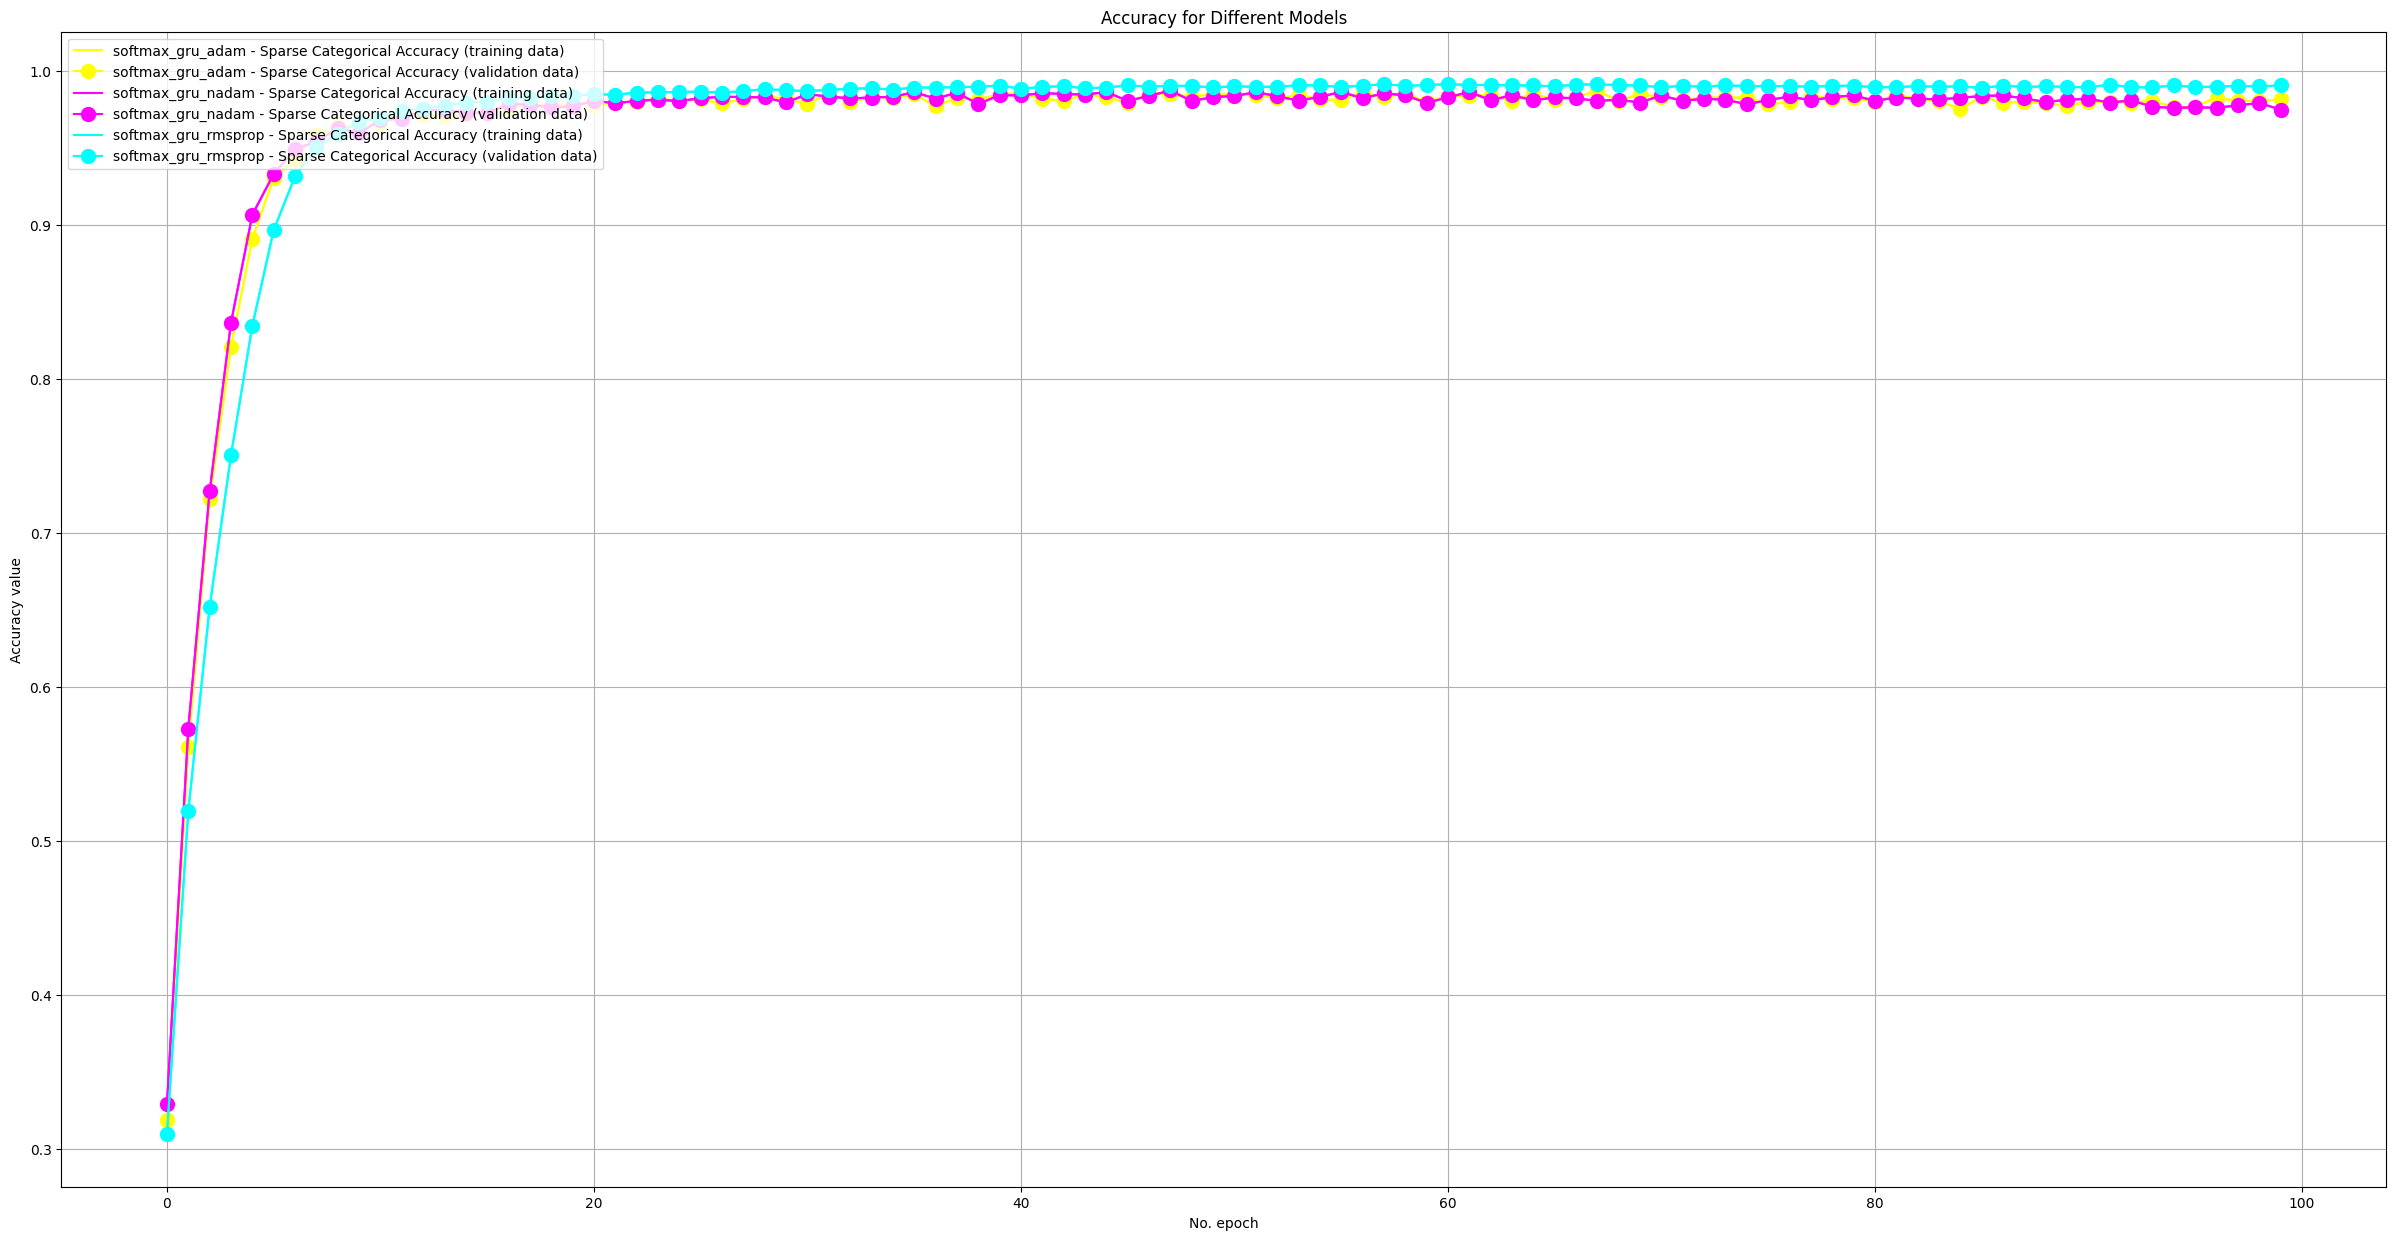

In [112]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (training data)', color=color_plot)
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [113]:
# lstm_model.evaluate(
#     x=features_tensor,
#     y=targets_tensor
# )

## Making Predictions

In [114]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

In [115]:
labels = [
    "Not Defined/Transient",
    "Baseline",
    "Stress",
    "Amusement",
    "Meditation",
    "Error/Not Labeled"
]

In [116]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

In [117]:
len(model_features_validation)

5193

In [118]:
features_tensor_validation = convert_to_tensor(
    np.array(
        [convert_to_tensor(data) for data in model_features_validation]
    )
)


In [119]:
features_tensor_validation

<tf.Tensor: shape=(5193, 60, 5), dtype=float64, numpy=
array([[[-4.65943125e-02, -9.04284684e-01, -6.64559137e-01,
         -4.89919394e-01,  1.63959898e-01],
        [ 1.51342789e-01,  8.11712260e-01, -1.93284080e+00,
         -1.14633667e+00,  3.45247980e-01],
        [-4.70135591e-01, -1.04226242e-01, -8.41134923e-01,
         -2.13595033e+00, -7.00115834e-01],
        ...,
        [-8.91612405e-01, -1.07396680e+00, -1.87933942e+00,
         -1.39711654e+00, -4.30786096e-02],
        [ 6.48519759e-02, -7.52638404e-01, -2.67509237e+00,
          3.69179308e-01,  4.86917491e-01],
        [-9.09065533e-01, -7.63304895e-01, -7.24960597e-01,
          2.49215201e-01,  2.21087009e-01]],

       [[ 1.51342789e-01,  8.11712260e-01, -1.93284080e+00,
         -1.14633667e+00,  3.45247980e-01],
        [-4.70135591e-01, -1.04226242e-01, -8.41134923e-01,
         -2.13595033e+00, -7.00115834e-01],
        [ 1.06858273e-01,  1.07392247e+00, -2.10743732e+00,
         -9.96365130e-01,  1.30739834e

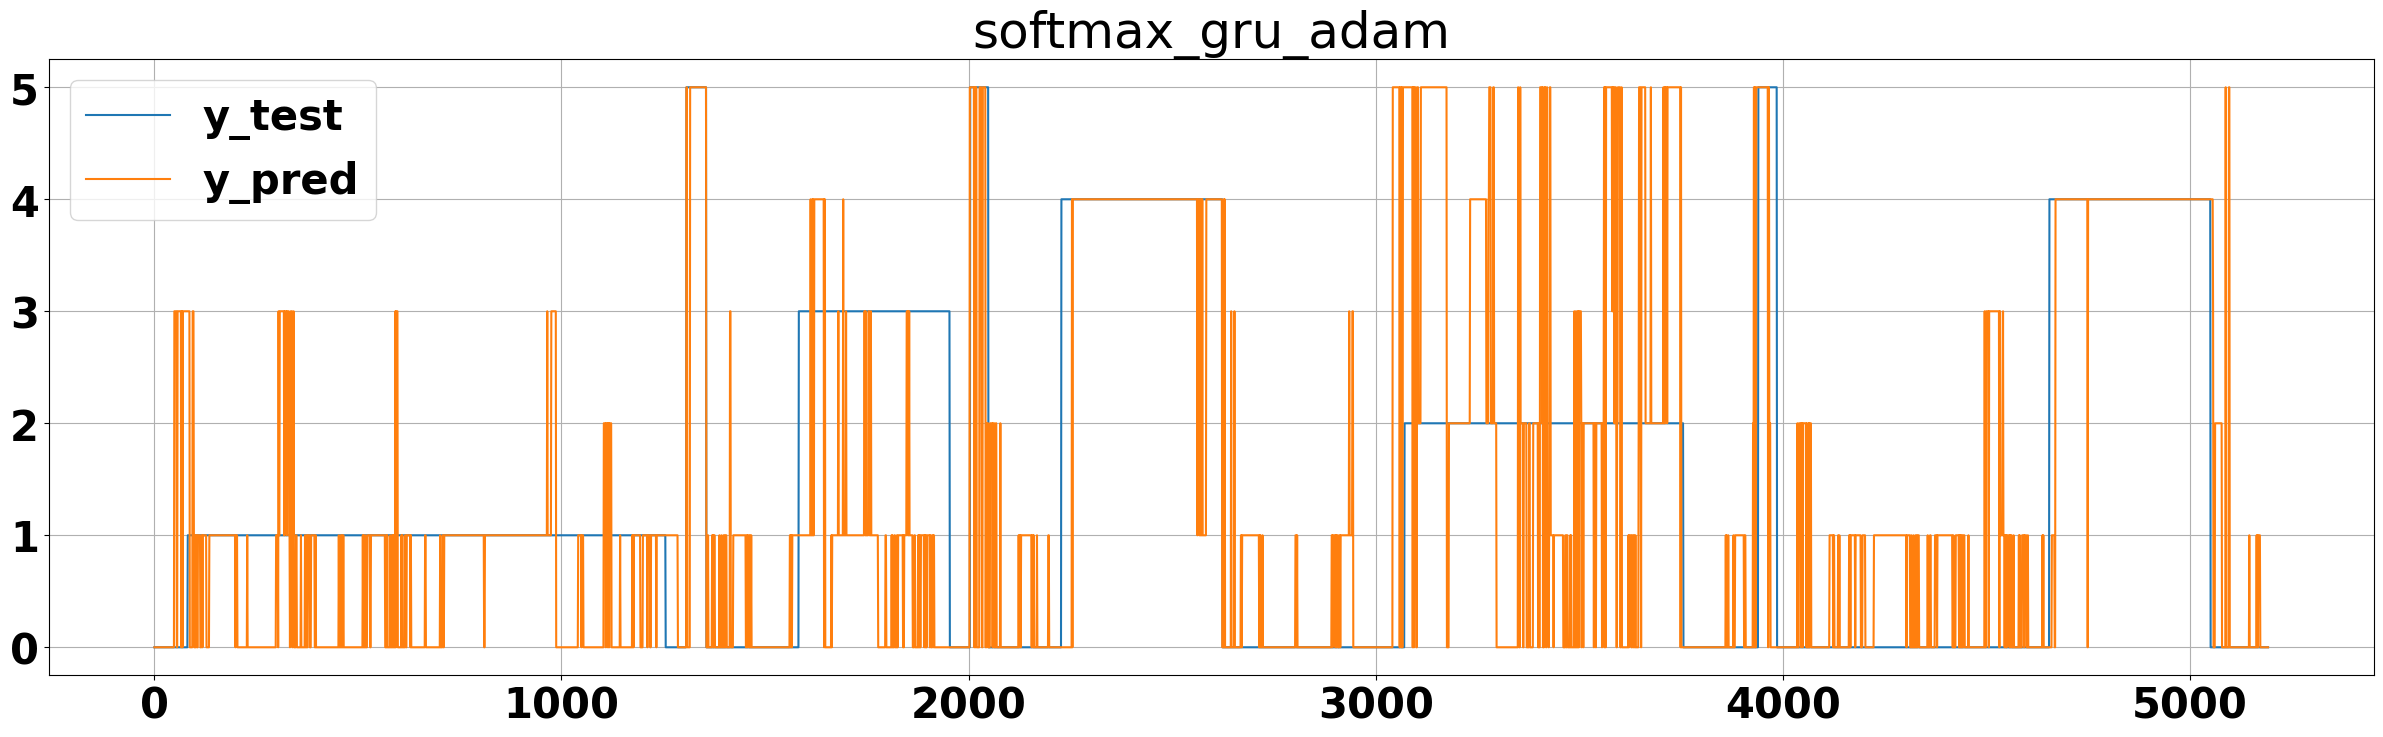

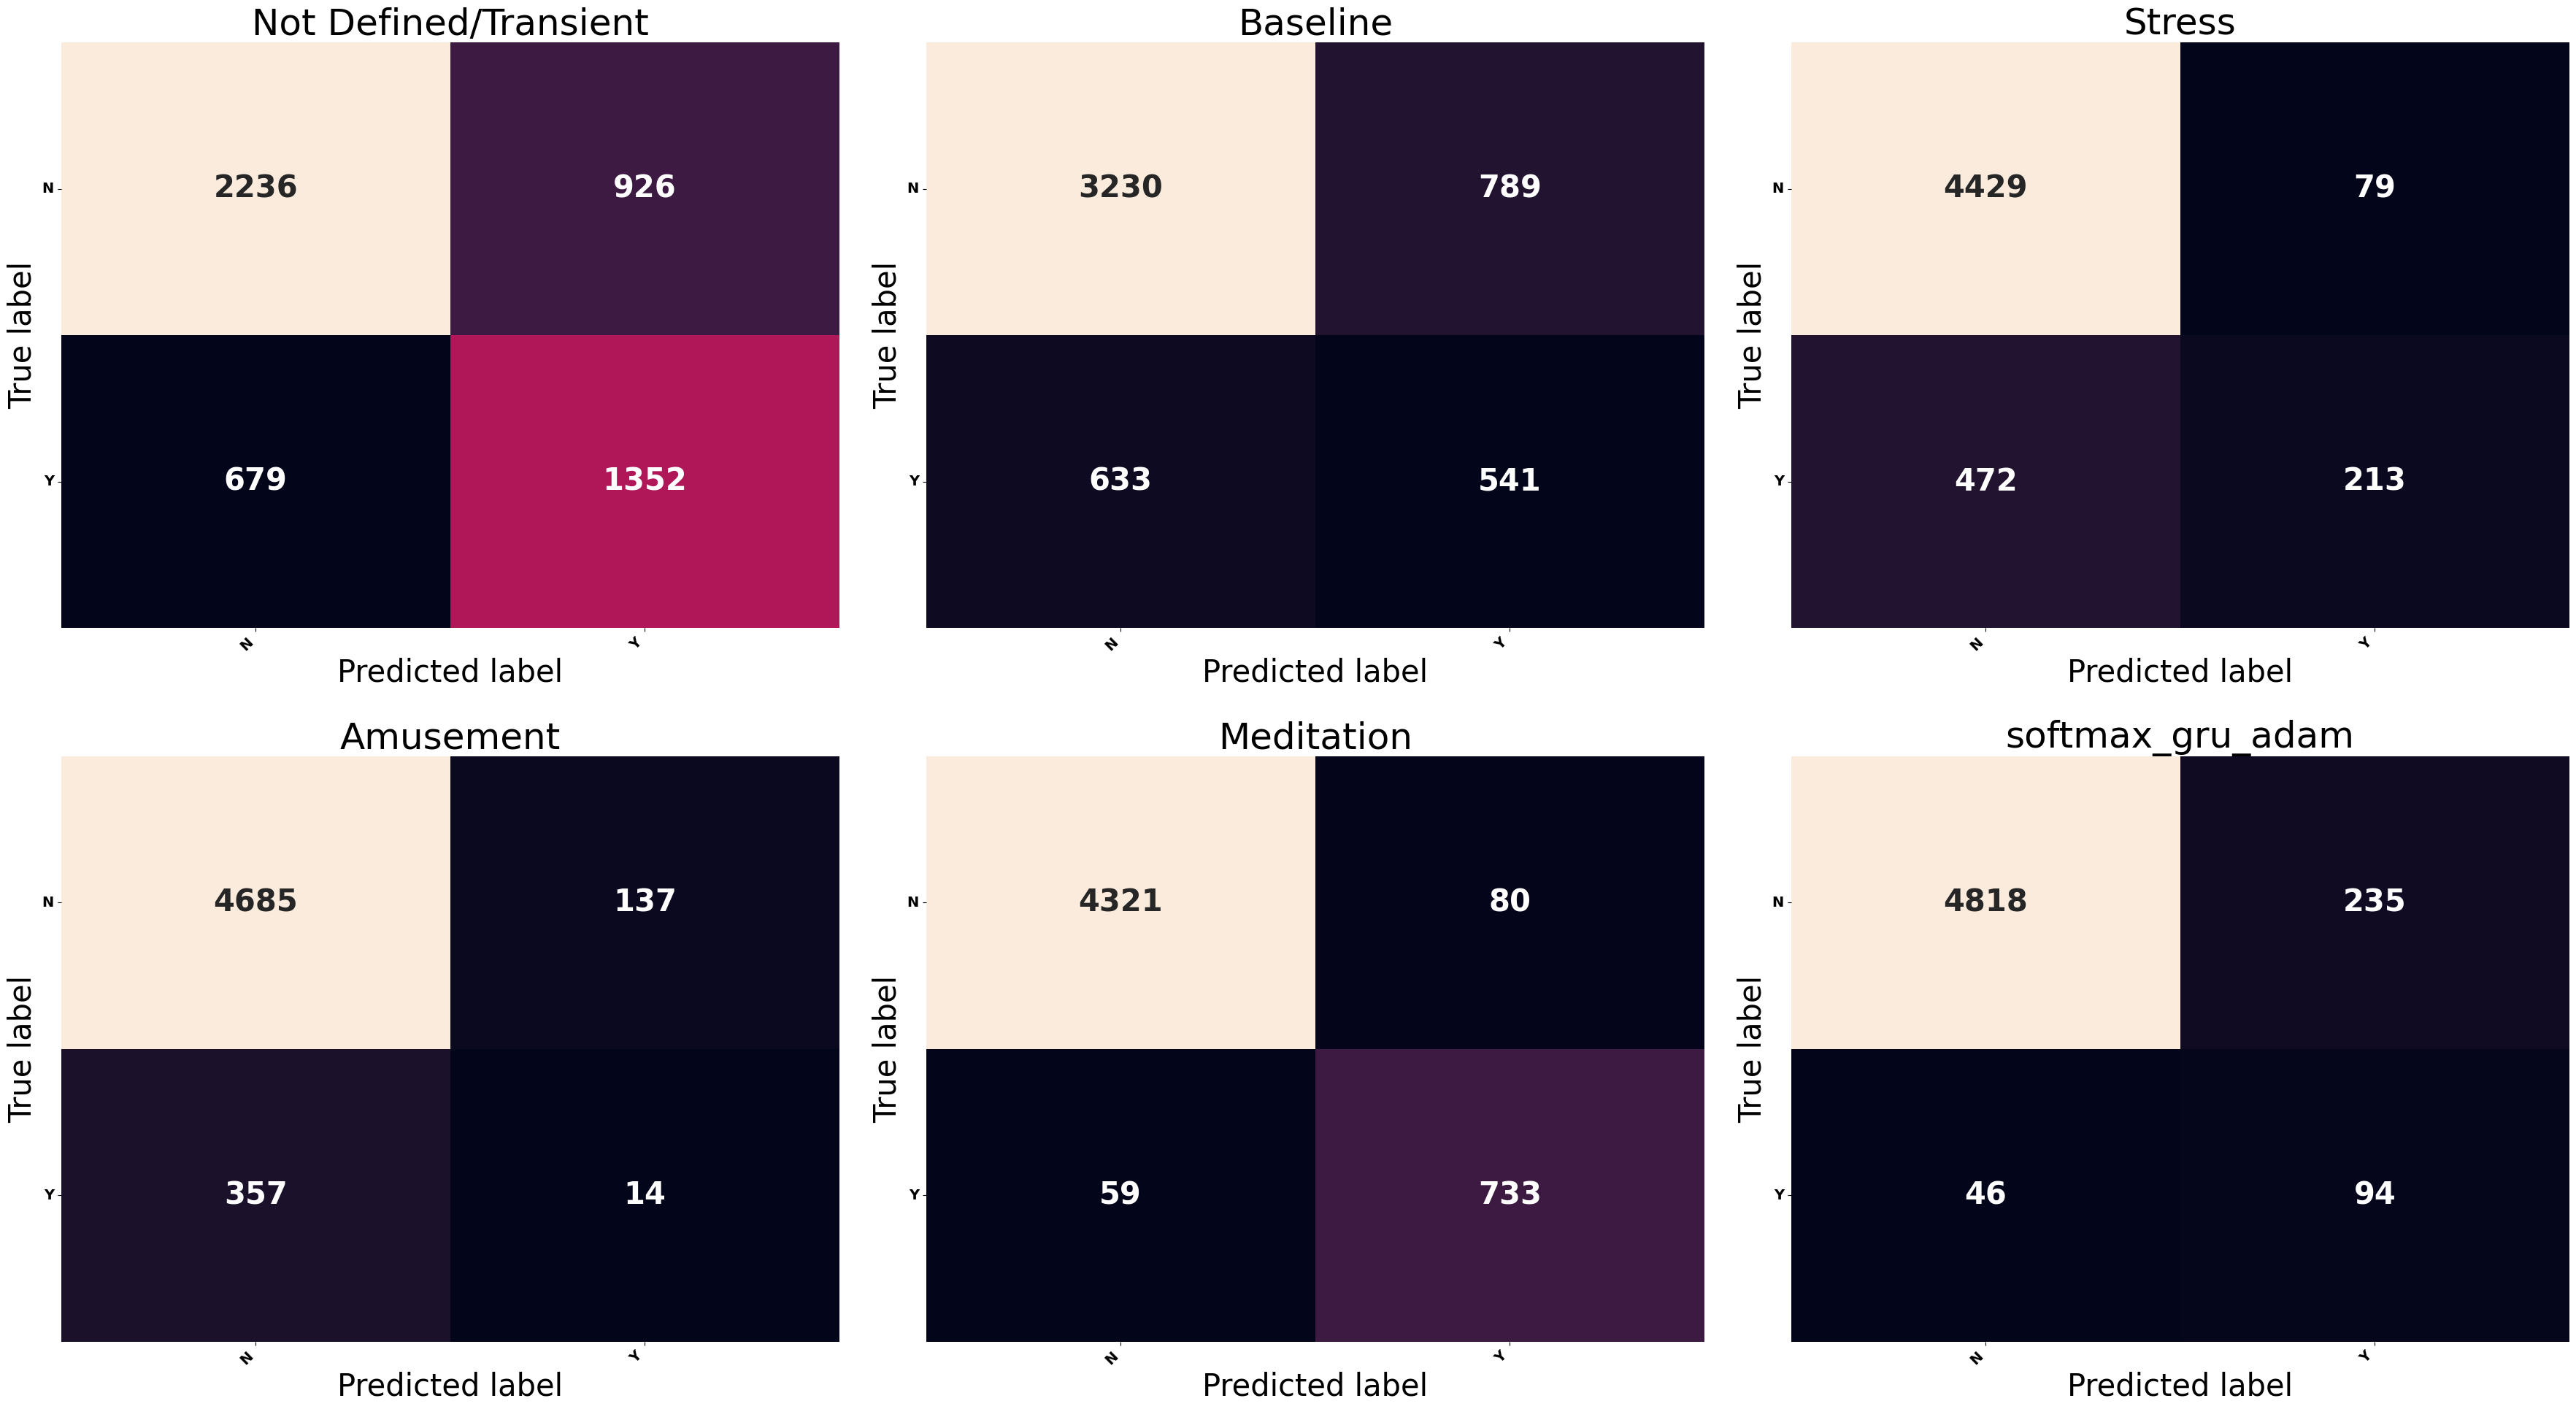

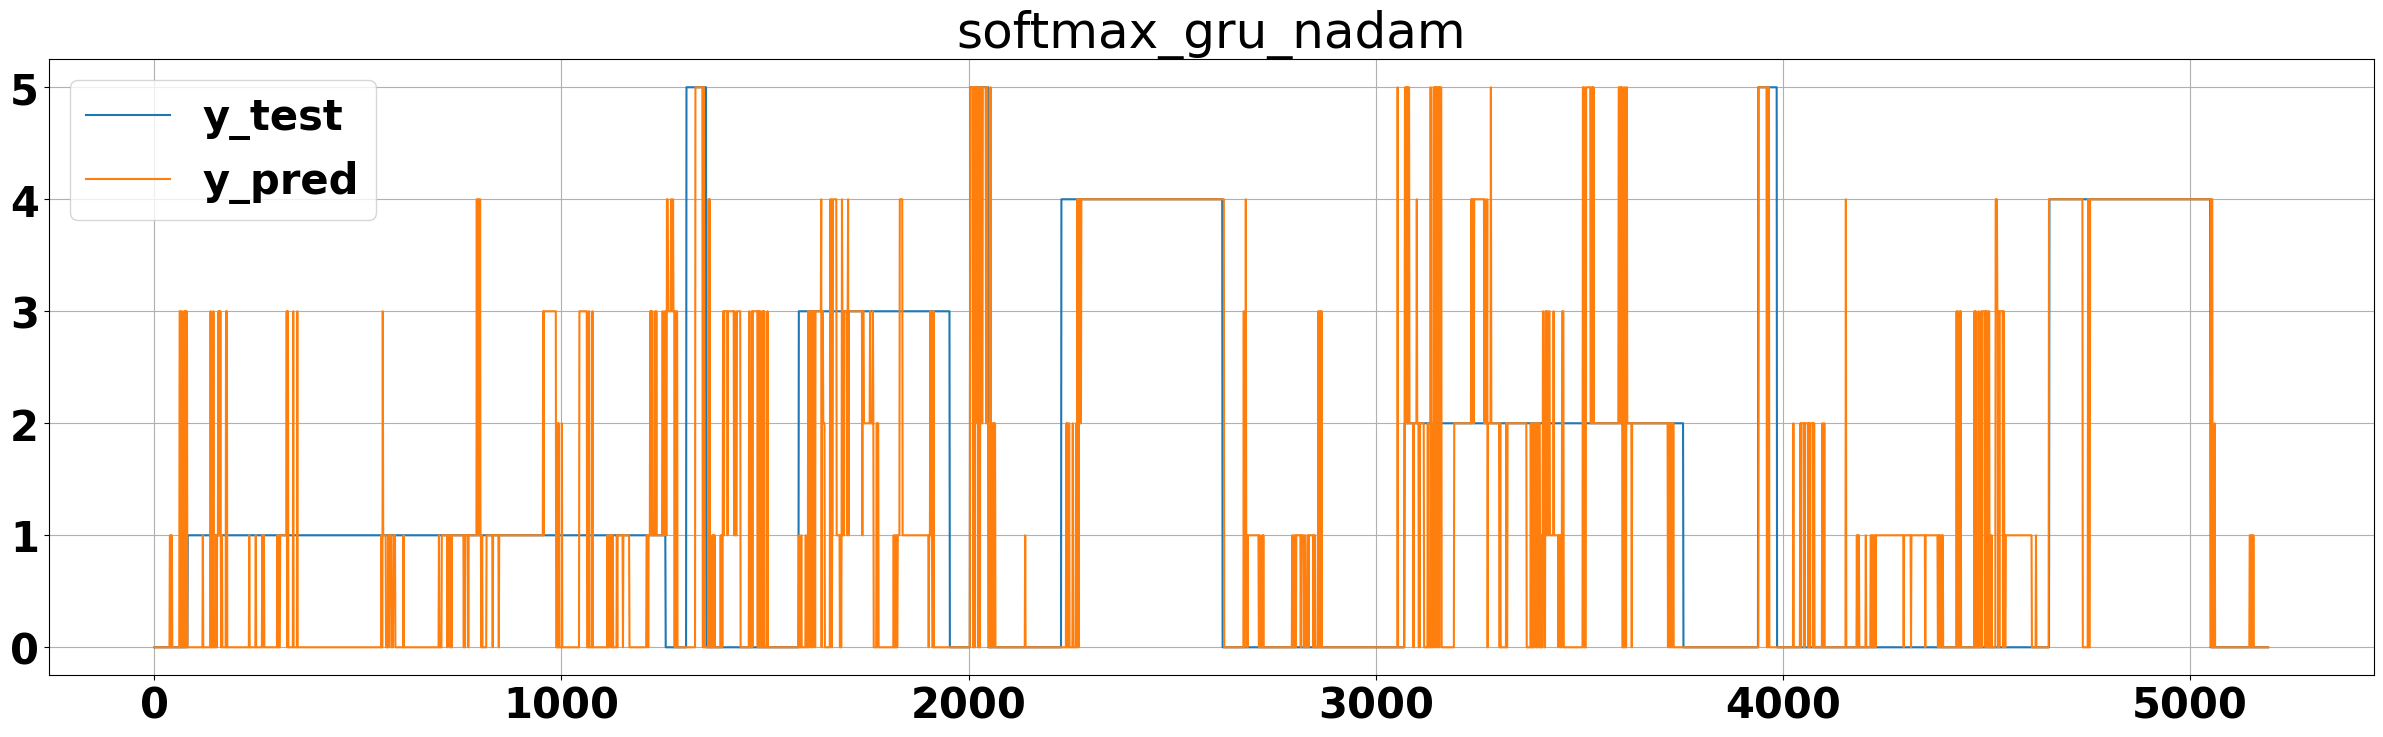

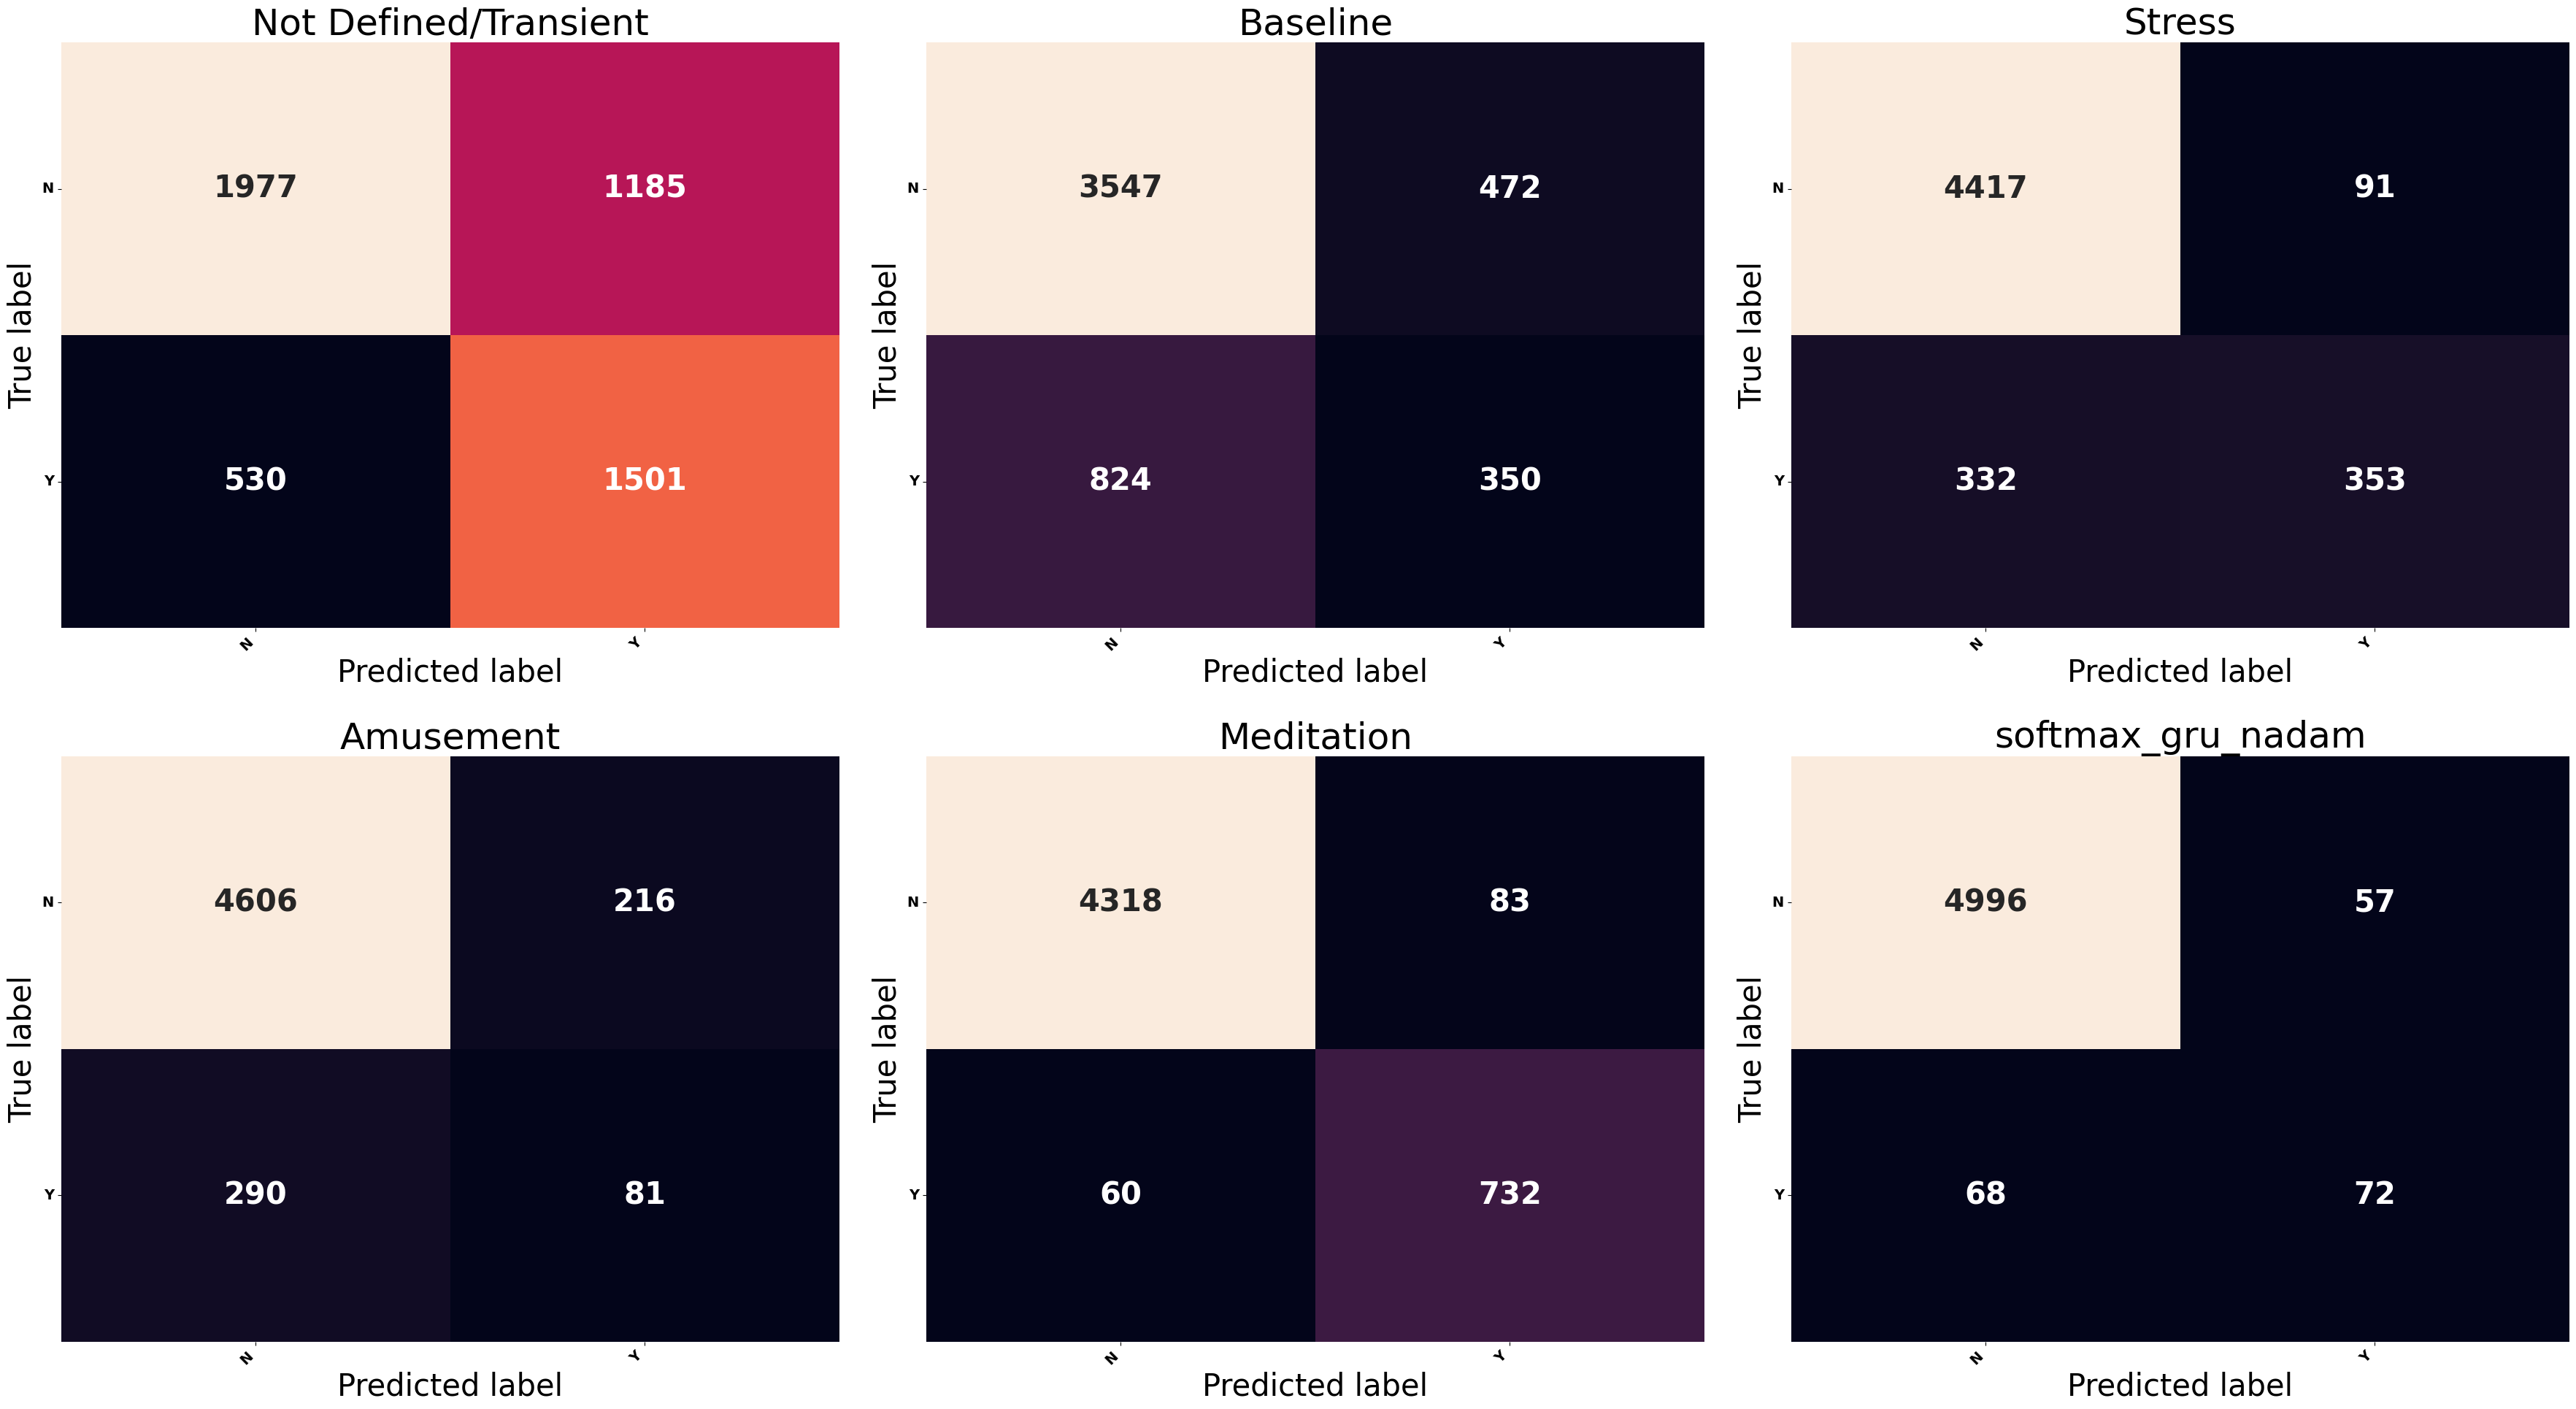

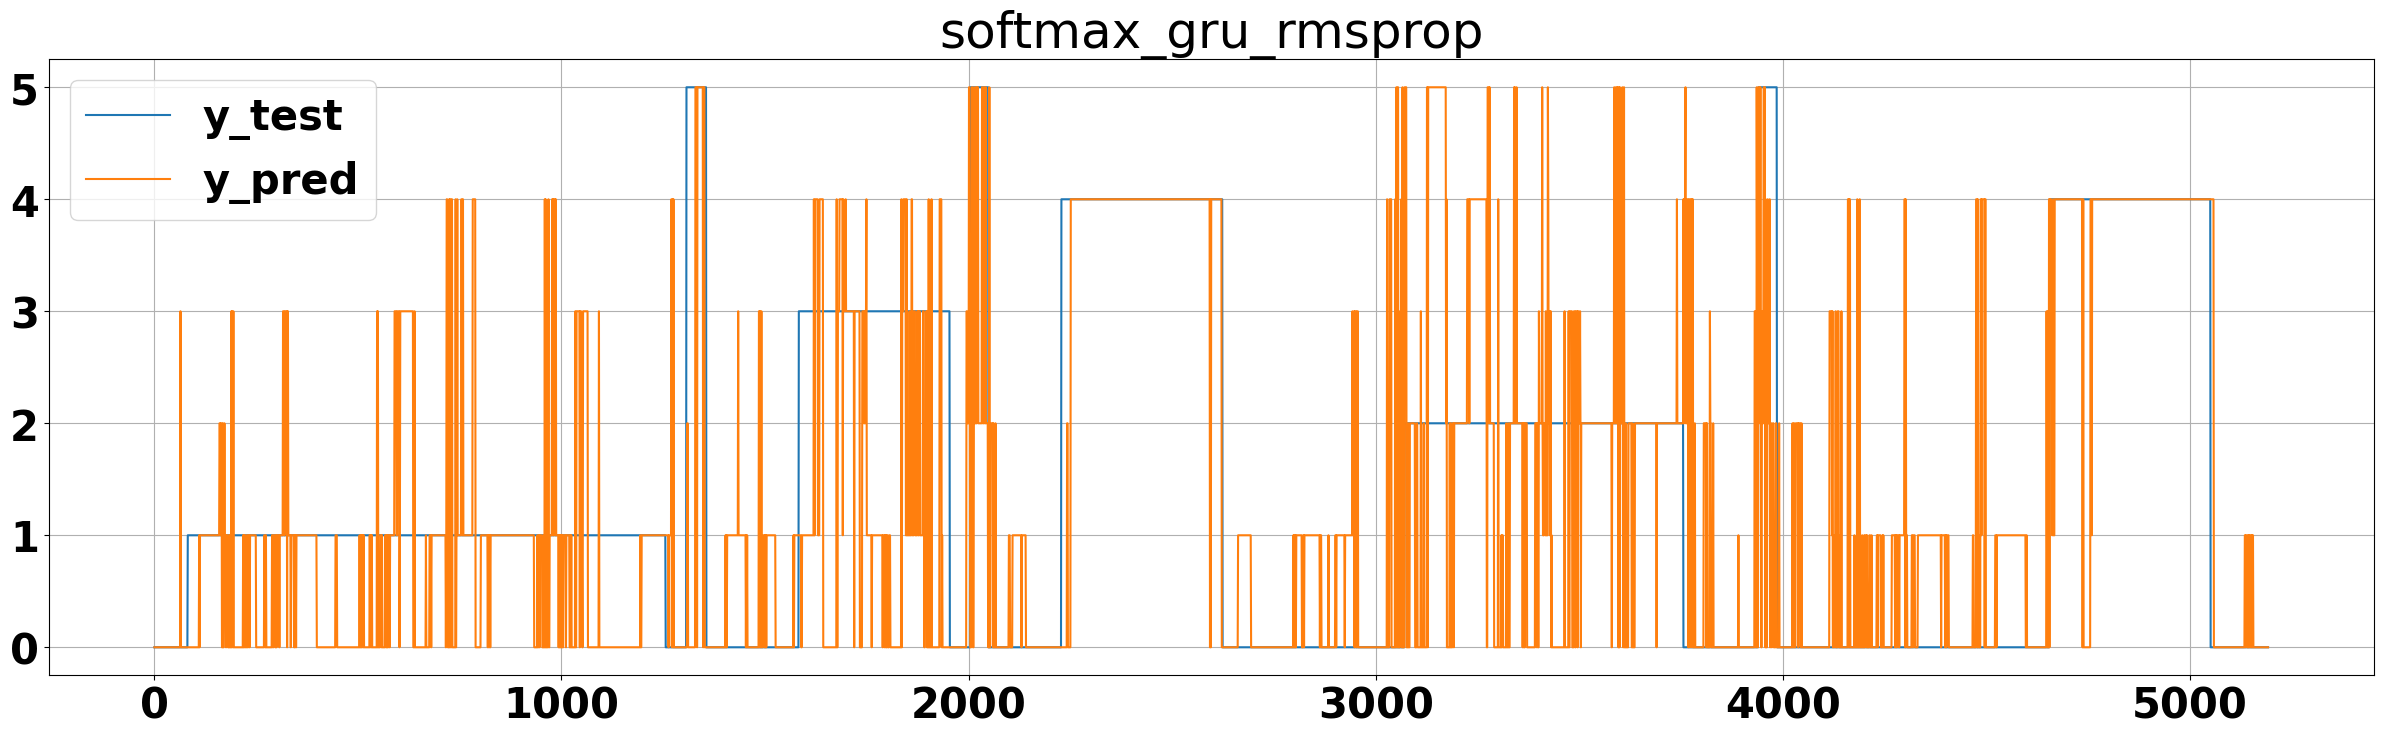

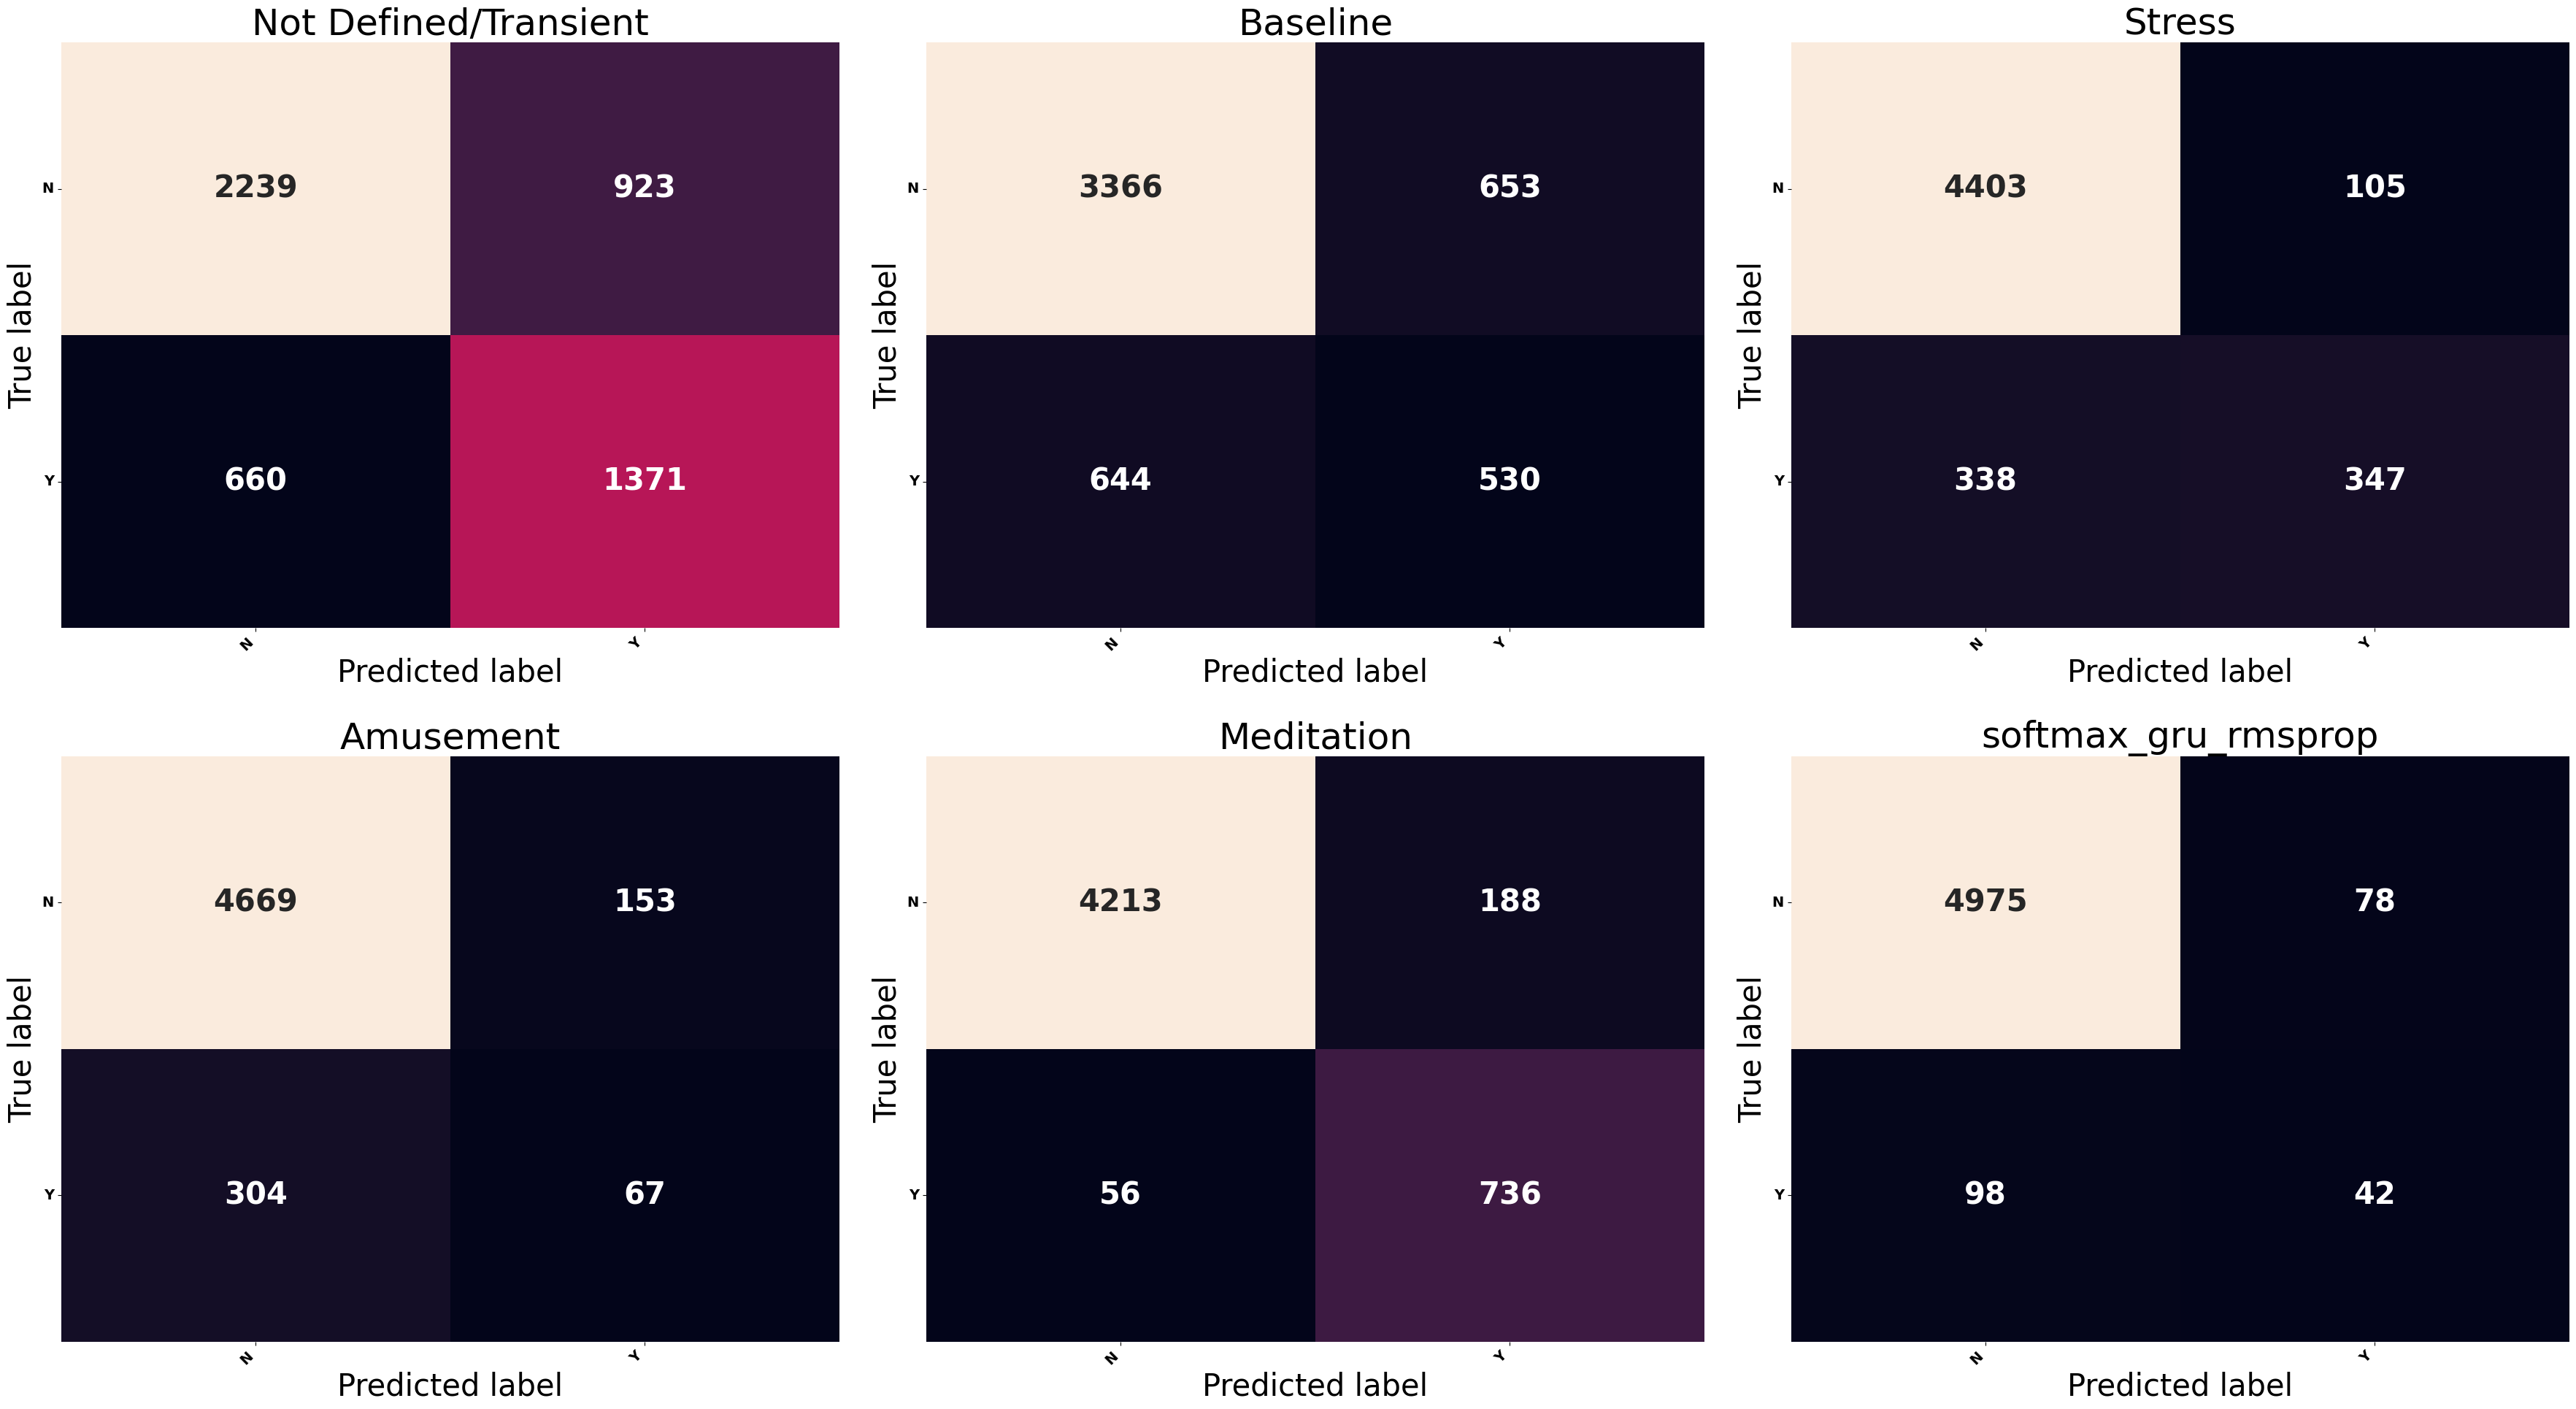

In [120]:
font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

y_test = model_targets_validation

for model_name in models_to_test:
    y_pred_prob = models_to_test[model_name]["model"].predict( x = features_tensor_validation )

    predictions = []
    for i in range(len(y_pred_prob)):
        predictions.append(np.argmax(y_pred_prob[i]))
    
    y_pred = np.array(predictions)
    models_to_test[model_name]["predictions"] = y_pred

    df_y = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })

    models_to_test[model_name]["pred_image"] = df_y.plot(figsize=(30, 8), grid=True).get_figure()
    plt.title(model_name)

    y_test_label = np.array([pacient_state[i] for i in y_test])
    y_pred_label = np.array([pacient_state[i] for i in y_pred])

    confusion_matrix = multilabel_confusion_matrix(y_test_label, y_pred_label, labels=labels)

    models_to_test[model_name]["confusion_matrix"] = confusion_matrix

    fig, ax = plt.subplots(2, 3, figsize=(36, 20))

    for axes, cf_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
        print_confusion_matrix(cf_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.title(model_name)
    
    models_to_test[model_name]["confusion_matrix_image"] = fig

In [121]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17b28e6d0>],
  'history': <keras.callbacks.History at 0x17cbc44c0>,
  'model': <keras.engine.sequential.Sequential at 0x17b2941f0>,
  'predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'pred_image': <Figure size 3000x800 with 1 Axes>,
  'confusion_matrix': array([[[2236,  926],
          [ 679, 1352]],
  
         [[3230,  789],
          [ 633,  541]],
  
         [[4429,   79],
          [ 472,  213]],
  
         [[4685,  137],
          [ 357,   14]],
  
         [[4321,   80],
          [  59,  733]],
  
         [[4818,  235],
          [  46,   94]]]),
  'confusion_matrix_image': <Figure size 3600x2000 with 6 Axes>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model

## Testing Area

In [122]:
# sigmoid_predictions = models_to_test["sigmoid"]["predictions"]
softmax_predictions = models_to_test["softmax"]["predictions"]
# no_activator_predictions = models_to_test["no_activatior"]["predictions"]

KeyError: 'softmax'

In [ ]:
# sigmoid_predictions
softmax_predictions
# no_activator_predictions

In [ ]:
softmax_predictions.shape

In [ ]:
sum(softmax_predictions[0])

In [ ]:
predictions = []
for i in range(len(softmax_predictions)):
    predictions.append(np.argmax(softmax_predictions[i]))

In [ ]:
len(predictions)

In [ ]:
predictions_array = np.array(predictions)

In [ ]:
predictions_array

In [ ]:
model_targets_validation

In [ ]:
targets_tensor_validation = tf.convert_to_tensor(model_targets_validation, dtype="int64")

In [ ]:
test_loss, test_acc = model.evaluate(features_tensor_validation, targets_tensor_validation, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
df_y = pd.DataFrame({
    "y_test": model_targets_validation,
    "y_pred": predictions_array
})

df_y.head(10)

In [ ]:
df_y.plot(figsize=(30, 8), grid=True)

In [ ]:
np.argmax(no_activator_predictions[0])

In [ ]:
max(no_activator_predictions)

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(range(len(no_activator_predictions)) ,no_activator_predictions)


In [ ]:
# sigmoid_predictions[0]
softmax_predictions[0]

In [ ]:
# sigmoid_predictions[1]
softmax_predictions[1]

In [ ]:
def test_predictions(predictions_test, num_labels):
    label_index_teste = np.argmax(predictions_test[0][:num_labels])
    state_index_teste = np.argmax(predictions_test[0][num_labels:])

    for array in predictions_test:
        if (label_index_teste != np.argmax(array[:num_labels])) and (state_index_teste != np.argmax(array[num_labels:])):
            print("Exist at least one different prediction")
            return
    print("Does not exist different predictions")


In [ ]:
test_predictions(softmax_predictions, num_labels)

In [ ]:
test_predictions(sigmoid_predictions, num_labels)

In [ ]:
test_predictions(no_activator_predictions, num_labels)

In [ ]:
def transform_prediction(prediction_np, num_states, num_labels):
    zeros_base_array = np.zeros(num_labels + num_states)

    label_index = np.argmax(prediction_np[:num_labels])
    state_index = np.argmax(prediction_np[num_labels:])

    zeros_base_array[label_index] = 1
    zeros_base_array[num_labels + state_index] = 1

    return zeros_base_array

In [ ]:
transformed_array_list = []


for prediction in sigmoid_predictions:
    binary_array = transform_prediction(prediction, num_states, num_labels).reshape(1, num_states + num_labels)
    transformed_array_list.append(binary_array)


In [ ]:
fittable_econder_array = np.concatenate(transformed_array_list, axis=0)

In [ ]:
unique_values = np.unique(fittable_econder_array, axis=0)

unique_values

In [ ]:
enc.inverse_transform(fittable_econder_array)

In [ ]:
enc.get_feature_names()

In [ ]:
target_validation_array_list = []

for array in model_targets_validation:
    target_validation_array_list.append(array.reshape(1,14))

target_validation_array = np.concatenate(target_validation_array_list, axis=0)

In [ ]:
target_validation_array

In [ ]:
target_validation_array[0]

In [ ]:
target_validation_array[1]

In [ ]:
unique_values1 = np.unique(target_validation_array, axis=0)

unique_values1

In [ ]:
np.concatenate(target_validation_array_list, axis=0)

In [ ]:
labeled_validation = enc.inverse_transform(model_targets_validation.tolist())

In [ ]:
labeled_validation